In [1]:
import utility_functions
import importlib
importlib.reload(utility_functions)
import clustering
importlib.reload(clustering)
import training
importlib.reload(training)

import shutil
import json
# import mxnet as mx
import numpy as np
import tensorflow as tf
import os
from os.path import join
from numpy.random import seed
from numpy import unique, where, savez_compressed
import random
import torch
import re
import keras
from tqdm import tqdm
from sklearn.utils.extmath import softmax
from datetime import datetime
import pickle
import itertools

# very important
# ! git clone https://github.com/yinguobing/arcface.git
from scipy.spatial.distance import cdist
from sklearn import metrics

seed(1)
tf.random.set_seed(2)

In [2]:
n_classes = 20000
n_clusters = 10

methods = ["full_random", "half_random", "kmeans", "sample_kmeans"]
if n_clusters == 1:
    method = methods[2]
else:
    method = methods[2]
# scenario_number = 'normal_' + str(n_classes) + '_' + method + str(n_clusters)
scenario_number = 'new_fake_' + str(n_classes) + '_' + method + str(n_clusters)
dataset_name = 'glint360k_224'
# scenario_number = str(n_classes) + '_half_random'

os.makedirs(join('..', dataset_name, 'data', scenario_number), exist_ok=True)
os.makedirs(join('..', dataset_name, 'models', scenario_number), exist_ok=True)

In [3]:
def current_time():
    return datetime.now().strftime('%y/%m/%d-%H:%M:%S')

def pprint(tpl, dataset_name='glint360k_224', endline=False, doubleendline=False):
    with open(join('..', dataset_name, 'data', str(scenario_number), 'results.txt'), 'a') as f:
        # r = ""
        # for t in tpl:
        #     r += " " + str(t)
        print(current_time(), tpl)
        print(current_time(), tpl, file=f)
        if endline:
            print('-'*15)
            print('-'*15, file=f)
        if doubleendline:
            print('-'*15)
            print('-'*15)
            print('*'*15, file=f)
            print('*'*15, file=f)

In [4]:
# منظور از لیبل، شماره عددی است و منظور از
# y
# برچسب غیرعددی است

train_embeddings_path = join('..', dataset_name, 'embeddings', 'common', 'all', 'train')
# test_embeddings_path = join('..', dataset_name, 'embeddings', 'common', 'all', 'val')
test_embeddings_path = join('F:\\test\deepface\\glint360k_224\\img_data\\embeddings', 'test')

trainx = []
trainl = []
trainy = []
traincenterx = []
traincentery = []
traincenterl = []
testx = []
testl = []
testy = []

# if os.path.isfile(join('..', dataset_name, 'data', str(n_classes), 'trainx.npz')):
if os.path.isfile(join('..', dataset_name, 'data', str(n_classes), 'new_testx.npz')):
    trainx = np.load(join('..', dataset_name, 'data', str(n_classes), 'trainx.npz'))['res']
    trainy = np.load(join('..', dataset_name, 'data', str(n_classes), 'trainy.npz'))['res']
    trainl = np.load(join('..', dataset_name, 'data', str(n_classes), 'trainl.npz'))['res']

    traincenterx = np.load(join('..', dataset_name, 'data', str(n_classes), 'traincenterx.npz'))['res']
    traincentery = np.load(join('..', dataset_name, 'data', str(n_classes), 'traincentery.npz'))['res']
    traincenterl = np.load(join('..', dataset_name, 'data', str(n_classes), 'traincenterl.npz'))['res']

    # testx = np.load(join('..', dataset_name, 'data', str(n_classes), 'testx.npz'))['res']
    # testy = np.load(join('..', dataset_name, 'data', str(n_classes), 'testy.npz'))['res']
    # testl = np.load(join('..', dataset_name, 'data', str(n_classes), 'testl.npz'))['res']

    testx = np.load(join('..', dataset_name, 'data', str(n_classes), 'new_testx.npz'))['res']
    testy = np.load(join('..', dataset_name, 'data', str(n_classes), 'new_testy.npz'))['res']
    testl = np.load(join('..', dataset_name, 'data', str(n_classes), 'new_testl.npz'))['res']

else:
    all_id_files = dict()
    with open(join('..', dataset_name, 'data', 'all_id_files.json')) as jsonfile:
        all_id_files = json.load(jsonfile)

    keys = list(all_id_files.keys())[:n_classes]
    
    os.makedirs(join('..', dataset_name, 'data', str(n_classes)), exist_ok=True)

    idx = 0
    for class_name in tqdm(keys):
        tr_x = np.load(join(train_embeddings_path, class_name + '.npz'), allow_pickle=True)
        tr_features = tr_x[tr_x.files[0]]    
        tr_f = len(tr_features)

        trainx.extend(tr_features)
        trainl.extend([idx] * tr_f)
        trainy.extend([class_name] * tr_f)

        traincenterx.append(np.mean(tr_features, axis=0))
        traincenterl.append(idx)
        traincentery.append(class_name)

        te_x = np.load(join(test_embeddings_path, class_name + '.npz'), allow_pickle=True)
        te_features = te_x[te_x.files[0]]
        te_f = len(te_features)

        testx.extend(te_features)
        testl.extend([idx] * te_f)
        testy.extend([class_name] * te_f)

        idx+=1

    trainx = np.array(trainx)
    trainy = np.array(trainy)
    trainl = np.array(trainl)
    traincenterx = np.array(traincenterx)
    traincentery = np.array(traincentery)
    traincenterl = np.array(traincenterl)
    testx = np.array(testx)
    testy = np.array(testy)
    testl = np.array(testl)

    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'trainx.npz'), res=trainx)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'trainy.npz'), res=trainy)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'trainl.npz'), res=trainl)

    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'traincenterx.npz'), res=traincenterx)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'traincentery.npz'), res=traincentery)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'traincenterl.npz'), res=traincenterl)

    # savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'testx.npz'), res=testx)
    # savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'testy.npz'), res=testy)
    # savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'testl.npz'), res=testl)

    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'new_testx.npz'), res=testx)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'new_testy.npz'), res=testy)
    savez_compressed(join('..', dataset_name, 'data', str(n_classes), 'new_testl.npz'), res=testl)    

In [5]:
# for idx, key in tqdm(enumerate(keys)):
#     source_name = os.path.join('F:\\test\deepface\\glint360k_224\\img_data\\embeddings', str(10 * (idx // 10) + 10) + '.npz')
#     f_name = os.path.join('F:\\test\deepface\\glint360k_224\\img_data\\embeddings', 'test', key + '.npz')
#     ten_features = np.load(source_name)['res']
#     np.savez_compressed(f_name, res=ten_features[5 * (idx % 10): 5 * ((idx % 10) + 1)])

In [6]:
pre_path = join('..', dataset_name, 'data', str(scenario_number))

if False: #os.path.isfile(join(pre_path, 'weights.pt')):
    weights = np.array(torch.load(join(pre_path, 'weights.pt')))
else:
    weights = []
    for i in range(n_classes):
        w = (len(np.where(testl == i)[0]))
        for s in range(w):
            weights.append(1/w)
    weights = np.array(weights)

    torch.save(torch.Tensor(weights), join(pre_path, 'weights.pt'))
    weights = np.array(torch.load(join(pre_path, 'weights.pt')))

In [ ]:
# knn with cosine similarity

cs = utility_functions.cos_sim(torch.Tensor(testx), torch.Tensor(traincenterx))
max_cs_values = cs.max(1)[0]
max_cs_args = cs.max(1)[1]
r = (max_cs_args.numpy() == testl) * weights
np.sum(r) / np.sum(weights)

0.97661006

In [ ]:
# knn with euclidean similarity

es = utility_functions.euc_sim(torch.Tensor(testx), torch.Tensor(traincenterx))
max_es_values = es.max(1)[0]
max_es_args = es.max(1)[1]
r = (max_es_args.numpy() == testl) * weights
np.sum(r) / np.sum(weights)

0.95212996

In [ ]:
# max_sample_size = 30
# new_trainx = []
# new_testx = []
# new_trainl = []
# new_trainy = []
# new_testy = []
# new_testl = []

# for idx in tqdm(range(n_classes)):
#     test_idxes = np.where(testl == idx)[0]
#     train_idxes = np.where(trainl == idx)[0]
#     test_features = testx[test_idxes]
#     train_features = trainx[train_idxes]
#     y = trainy[train_idxes[0]]
#     l = trainl[train_idxes[0]]
    
#     # if len(train_features) >= (max_sample_size * 2) // 3:
#     #     train_features = train_features[:max_sample_size // 3 * 2]
#     # if len(test_features) >= (max_sample_size // 3):
#     #     test_features = test_features[:max_sample_size // 3]

#     features = np.array(list(train_features) + list(test_features))

#     if len(features) >= max_sample_size:
#         new_trainx.extend(list(train_features))
#         # new_testx.extend(list(test_features))
#         new_trainy.extend([y] * len(list(train_features)))
#         # new_testy.extend([y] * len(list(test_features)))
#         new_trainl.extend([l] * len(list(train_features)))
#         # new_testl.extend([l] * len(list(test_features)))
#         continue

#     d = utility_functions.cos_sim(torch.Tensor(features), torch.Tensor(features))
#     for i in range(len(d)):
#         d[i,i] = 0
#     m = np.sum(d.numpy(), 0) / (len(d) - 1)
#     candidates = np.argsort(m)[::-1][:np.min([len(d), 8])]

#     passed = []
#     new_features = []
#     ll = list(itertools.product(range(len(candidates)), range(len(candidates))))
#     np.random.shuffle(ll)

#     for i, j in ll:
#         if i == j:
#             continue
#         if (j, i) in passed:
#             continue
#         passed.append((i, j))

#         new_feature = np.mean([features[i], features[j]], 0)
#         new_features.append(list(new_feature))
#         if len(new_features) + len(features) >= max_sample_size:
#             terminate = True

#     if len(features) > 7:
#         x = max_sample_size // 3 * 2 - len(train_features)
#         new_trainx.extend(list(train_features) + list(new_features[:x]))
#         # new_testx.extend(list(test_features) + list(new_features[x : x + max_sample_size // 3 - len(test_features)]))
#         new_trainy.extend([y] * (max_sample_size // 3 * 2))
#         # new_testy.extend([y] * (max_sample_size // 3))
#         new_trainl.extend([l] * (max_sample_size // 3 * 2))
#         # new_testl.extend([l] * (max_sample_size // 3))
#     else:
#         x = int(len(train_features) / len(features) * len(new_features))
#         new_trainx.extend(list(train_features) + list(new_features[:x]))
#         # new_testx.extend(list(test_features) + list(new_features[x:]))
#         new_trainy.extend([y] * len(list(train_features) + list(new_features[:x])))
#         # new_testy.extend([y] * len(list(test_features) + list(new_features[x:])))
#         new_trainl.extend([l] * len(list(train_features) + list(new_features[:x])))
#         # new_testl.extend([l] * len(list(test_features) + list(new_features[x:])))        

In [ ]:
# from sklearn.decomposition import PCA
  
# pca = PCA(n_components = 2)
  
# X_train = pca.fit_transform(trainx[:6])
# X_test = pca.transform(trainx[6:])
  
# explained_variance = pca.explained_variance_ratio_
# explained_variance

In [ ]:
# from sklearn.linear_model import LogisticRegression  
  
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train, y_train)

In [ ]:
# o_test_features = testx[np.where(testl == 2)[0]]
# o_train_features = trainx[np.where(trainl == 2)[0]]
# o_features = np.array(list(o_train_features) + list(o_test_features))
# o_d = utility_functions.cos_sim(torch.Tensor(o_features), torch.Tensor(o_features))
# np.mean(o_d.numpy(), 0)

In [ ]:
# z_o_d = utility_functions.cos_sim(torch.Tensor(z_features), torch.Tensor(o_features))
# np.mean(z_o_d.numpy(), 0)

In [ ]:
# temp_testx = []
# temp_testy = []
# temp_testl = []

# for i in range(n_classes):
#     idx = np.where(testl == i)[0][0]
#     temp_testx += [testx[idx]]
#     temp_testy += [testy[idx]]
#     temp_testl += [testl[idx]]

In [ ]:
# import utility_function

# for i in tqdm(range(n_clusters)):
#     x = np.array([])
#     A = traincenterx[unique_result[i]]
#     B = traincenterx[unique_result[i]]

#     c = cdist(A, B, 'cosine')
    
#     for j in range(len(A)):
#         c[j, j] = np.Inf

#     # c = (c - minn) / (maxx - minn)
#     x = np.where(c < 0.6)
    
#     xx = unique_result[i].copy()
#     new_unique_result[i] = np.delete(xx, list(set(x[0])))
#     extra.extend(list(set(xx[x[0]])))

# i = 5
# new_unique_result[5] = np.array(extra)
# n_clusters = 6
# for r in tqdm(range(n_clusters)):
#     train_ids = utility_functions.train_calc_ids(new_unique_result[r], trainy, trainl, r)
#     test_ids = utility_functions.test_calc_ids(new_unique_result[r], trainy, trainl, r)
#     train_sample_count, test_sample_count = utility_functions.convert_emb_to_tfrecord(dataset_name, scenario_number, train_ids, test_ids, r, overwrite=True, all_samples=True, n_classes=len(new_unique_result[r]))
#     train_dataset, test_dataset = utility_functions.prepare_data_sets(dataset_name, scenario_number, train_ids, test_ids, r)    
#     training.softmax_train(dataset_name, scenario_number, train_dataset, test_dataset, new_unique_result[r], trainx, trainy, trainl, r, epochs=30,train_overwrite=False, freq = train_sample_count // 100)
#     val_acc = utility_functions.test_acc_calc(r, test_dataset, dataset_name, scenario_number)

In [ ]:
# trainx = np.array(new_trainx)
# trainy = np.array(new_trainy)
# # testx = np.array(new_testx)
# # testy = np.array(new_testy)
# trainl = np.array(new_trainl)
# # testl = np.array(new_testl)

In [ ]:
importlib.reload(utility_functions)
importlib.reload(clustering)
importlib.reload(training)
m = 'euclidean'

for test_number in range(0, 1):
# for meth in ["full_random"]:
    # scenario_number = str(n_classes) + '_' + meth

    os.makedirs(join('..', dataset_name, 'models', scenario_number), exist_ok=True)
    os.makedirs(join('..', dataset_name, 'models', scenario_number, str(test_number)), exist_ok=True)

    pprint(("meth = ", method, "test_number = ", str(test_number)))
    dir_path = join('..', dataset_name, 'data', str(scenario_number), 'tfrecords')
    # dir_path2 = join('..', dataset_name, 'models', str(scenario_number))
    # try:
    #     shutil.rmtree(dir_path)
    #     # shutil.rmtree(dir_path2)
    # except OSError as e:
    #     print("Error: %s : %s" % (dir_path, e.strerror))

    if method == "kmeans" or method == 'sample_kmeans':
        result_path = join('..', dataset_name, 'data', scenario_number,  'result_' + str(test_number) + '.npz')    
        model_filename = join('..', dataset_name, 'models', scenario_number, 'kmeans_' + str(test_number) + '.sav')
    elif method == 'full_random' or method == 'half_random':
        result_path = join('..', dataset_name, 'data', scenario_number, 'result_' + str(test_number) + '.npz')
    result = dict()
    unique_result = dict()

    if method == 'full_random':
        if os.path.isfile(result_path): # and os.path.isfile(filename):
            result = (np.load(result_path, allow_pickle=True)['res']).item()
        else:
            # # random 
            lbls = np.zeros((n_classes), dtype='int')
            for i in range(n_classes):
                lbls[i] = random.randint(0, n_clusters-1)
            for i in range(n_clusters):
                result[i] = torch.Tensor((lbls == i).nonzero()).squeeze(0).unsqueeze(1).cuda().int().cpu().numpy().squeeze(1)
            savez_compressed(result_path, res = result)
        for r in result:
            unique_result[r] = result[r]
    elif method == 'half_random':
        result = (np.load(result_path, allow_pickle=True)['res']).item()
        for r in result:
            unique_result[r] = result[r]
    elif method == 'kmeans':
        if False: #os.path.isfile(result_path) and os.path.isfile(model_filename):
            kmeans_model = pickle.load(open(model_filename, 'rb'))
            result = (np.load(result_path, allow_pickle=True)['res']).item()
        else:
            centers, labels = clustering.init_centers(trainx, n_clusters)
            kmeans_model = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, centroids=centers, mode=m, minibatch=None)
            lbls = kmeans_model.fit_predict(torch.Tensor(traincenterx).cuda())
            pickle.dump(kmeans_model, open(model_filename, 'wb'))
            for i in range(n_clusters):
                result[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)
            savez_compressed(result_path, res = result)
        for r in result:
            unique_result[r] = result[r]
    elif method == 'sample_kmeans':
        kmeans_model = None

        if os.path.isfile(model_filename) and os.path.isfile(result_path):
            kmeans_model = pickle.load(open(model_filename, 'rb'))
            result = (np.load(result_path, allow_pickle=True)['res']).item()
        else:
            centers, labels = clustering.init_centers(trainx, n_clusters)
            kmeans_model = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, centroids=centers, mode=m, minibatch=None)
            lbls = model.fit_predict(torch.Tensor(trainx).cuda())
            pickle.dump(kmeans_model, open(model_filename, 'wb'))
            for i in range(n_clusters):
                result[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)
            savez_compressed(result_path, res = result)

        for r in result:
            unique_result[r] = np.unique(trainl[result[r]])

    if method == 'half_random':
        alpha = 0.4
        alpha_sw = True
        while(alpha_sw):
            temp = dict()
            temp_unique_result = unique_result.copy()
            for i in range(n_clusters):
                while(True):
                    A = torch.Tensor(traincenterx[temp_unique_result[i]])
                    c = utility_functions.cos_sim(A, A).numpy()
                    x = np.where((c > alpha) & (c < 0.99))

                    if len(x[0]) == 0:
                        break
                    # کلاسهایی که باید منتقل شوند
                    result = []
                    sw = False
                    for idx, l in enumerate(x[0]):
                        if l in result:
                            continue
                        sw = False
                        for k, res in enumerate(result):
                            idxes = np.where(x[0] == res)[0]
                            for id in idxes:
                                if l == x[1][id]:
                                    sw = True
                        if sw:
                            continue
                        result.append(l)
                
                    t = result
                    if i in temp:
                        temp[i] = np.append(temp[i], temp_unique_result[i][t])
                    else:
                        temp[i] = temp_unique_result[i][t]
                    temp_unique_result[i] = np.delete(temp_unique_result[i], t)

            lst = np.argsort([len(temp_unique_result[i]) for i in range(n_clusters)])
            for t in temp:
                for l in lst:
                    A = torch.Tensor(traincenterx[temp[t]])
                    B = torch.Tensor(traincenterx[temp_unique_result[l]])

                    c = utility_functions.cos_sim(A, B)
                    d = np.where((c > alpha) & (c < 0.99))

                    e = np.delete(temp[t], d[0])
                    temp_unique_result[l] = np.append(temp_unique_result[l], list(set(e))).astype('int')
                    temp[t] = temp[t][list(set(d[0]))]

                    if len(temp[t]) == 0:
                        break
                lst = np.argsort([len(temp_unique_result[i]) for i in range(n_clusters)])


            # if sum([len(temp[i]) for i in temp]) > 0:
            #     alpha += 0.01
            # else:
            alpha_sw = False

        unique_result = temp_unique_result
        pprint(('alpha', alpha))
        # # temp
        # for t in temp:
        #     if len(temp[t]) > 0:
        #         for item in temp[t]:
        #             r = np.random.randint(n_clusters)
        #             unique_result[r] = np.append(unique_result[r], [item])

23/01/08-06:04:48 ('meth = ', 'kmeans', 'test_number = ', '0')


In [ ]:
%%capture

test_number = 0
for r in (range(n_clusters)):
    pprint(('cluster', str(r)))
    train_ids = utility_functions.train_calc_ids(unique_result[r], trainy, trainl, r)
    test_ids = utility_functions.test_calc_ids(unique_result[r], trainy, trainl, r)
    train_sample_count, test_sample_count = utility_functions.convert_emb_to_tfrecord(dataset_name, scenario_number, train_ids, test_ids, r, overwrite=False, all_samples=True, n_classes=len(unique_result[r]))
    train_dataset, test_dataset = utility_functions.prepare_data_sets(dataset_name, scenario_number, train_ids, test_ids, r)    
    # training.softmax_train(dataset_name, scenario_number, train_dataset, test_dataset, unique_result[r], trainx, trainy, trainl, r, test_number=test_number, epochs=50,train_overwrite=False, freq = train_sample_count // 100)
    training.softmax_train(dataset_name, scenario_number, train_dataset, unique_result[r], trainx, trainy, trainl, r, test_number=test_number, epochs=50,train_overwrite=False, freq = train_sample_count // 100)
    # val_acc = utility_functions.test_acc_calc(r, test_dataset, dataset_name, scenario_number, test_number=test_number)
    # pprint(('val_acc : ', str(val_acc)))

INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\1\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\2\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\3\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\4\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\5\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\6\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\7\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\hrnetv2\8\assets
INFO:tensorflow:Assets written to: ../glint360k_224/models/new_fake_20000_kmeans10/0/0\exported\

In [ ]:
# frequency = 1000
# sub_index = 0
# num_ids = len(result[0])

# name = "hrnetv2"
# if test_number != None:
#     export_dir = os.path.join('./glint360k_224/models/' , scenario_number , str(test_number), str(sub_index), 'exported', name)
# else:
#     export_dir = os.path.join('./glint360k_224/models/' , scenario_number, str(sub_index), 'exported', name)

# input_shape = (512,)
# # num_ids = len(cluster)
# regularizer = keras.regularizers.L2(5e-4)
# name = "hrnetv2"

# model = keras.Sequential([keras.Input(input_shape), \
#     # tf.keras.layers.Dense(256, activation='relu'), \
#     # tf.keras.layers.Dense(128, activation='relu'), \
#     training.L2Normalization(), \
#     training.ArcLayer(num_ids, regularizer)], \
#     name="training_model")

# loss_fun = training.ArcLoss(n_classes=num_ids)

# optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True, epsilon=0.001)

# path = None
# if test_number != None:
#     path = './glint360k_224/models/' + scenario_number + '/' + str(test_number) + '/' + str(sub_index)
# else:
#     path = './glint360k_224/models/' + scenario_number + '/' + str(sub_index)

# supervisor = training.TrainingSupervisor(model,
#                                 optimizer,
#                                 loss_fun,
#                                 train_dataset,
#                                 path,
#                                 frequency,
#                                 "categorical_accuracy",
#                                 'max',
#                                 name,
#                                 num_ids)
# model.summary()

In [ ]:
# preds = []
# batch_size = 500
# batch_numbers = len(testx) // batch_size + (1 if len(testx) % batch_size != 0 else 0)
# for i in tqdm(range(batch_numbers)):
#     preds.extend(np.argmax(model(testx[i * batch_size : np.min([(i + 1) * batch_size, len(testx)])]), axis=1))

# trues = 0
# falses = 0
# for idx in range(len(preds)):
#     if testl[idx] == preds[idx]:
#         trues += weights[idx]
#     else:
#         falses += weights[idx]
#     if idx % 1000 == 0 and idx > 0:
#         print((trues + falses) / n_classes, trues / (trues + falses))

In [ ]:
# # # supervisor.restore(True)
# checkpoint = tf.train.Checkpoint(model)
# supervisor.checkpoint.restore(supervisor.manager.latest_checkpoint)

In [ ]:
# for t in test_dataset:
#     print(t)
#     break

In [ ]:
# np.argmax(model(t[0]), 1), t[1]


In [ ]:
# # only for one cluster
# sub = 0
# test_number = 0
# model = tf.keras.models.load_model(os.path.join('..', dataset_name, 'models', str(scenario_number),  str(test_number), str(sub), 'exported', 'hrnetv2'))

# lbls = []
# preds = []
# for test in tqdm(test_dataset):
#     lbls.extend(test[1].numpy())
#     preds += list(np.argmax(model(test[0]), axis=1))

# trues = 0
# falses = 0
# for idx in range(np.min([len(lbls), len(weights)])):
#     if lbls[idx] == preds[idx]:
#         trues += weights[idx]
#     else:
#         falses += weights[idx]
# val_acc = trues / (trues + falses)
# pprint(('val_acc for cluster ', sub, ' is : ', val_acc ))

In [ ]:
# n_classes = 1000
# n_clusters = 1

# methods = ["full_random", "half_random", "kmeans", "sample_kmeans"]
# method = methods[2]
# # scenario_number = 'normal_' + str(n_classes) + '_' + method + str(n_clusters)
# scenario_number = 'new_fake_' + str(n_classes) + '_' + method + str(n_clusters)
# dataset_name = 'glint360k_224'
# # scenario_number = str(n_classes) + '_half_random'

# result_path = join('..', dataset_name, 'data', scenario_number,  'result_' + str(test_number) + '.npz')    
# result = (np.load(result_path, allow_pickle=True)['res']).item()
# unique_result = result

In [ ]:
test_number = 0

model = None
batch_softmax = None
batch_argmax_softmax = None
batch_max_softmax = None

softmax_prediction = dict()
batch_size = 1000
# batch_number = len(temp_testx) // batch_size + (1 if (len(temp_testx) % batch_size != 0) else 0)
batch_number = len(testx) // batch_size + (1 if (len(testx) % batch_size != 0) else 0)

max_softmax = dict()
argmax_softmax = dict()

for idx in tqdm(range(n_clusters)):    
    # print(idx)
    if False: #os.path.isfile(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_max.npz')) and os.path.isfile(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_argmax.npz')):
        max_softmax[idx] = np.load(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_max.npz'))['res']
        argmax_softmax[idx] = np.load(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_argmax.npz'))['res']
    else:
        # model_path=join('..', dataset_name, 'models', str(scenario_number), str(0) + '_best_model.h5')
        model_path = join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx), 'exported', 'hrnetv2')
        # with tf.device('/cpu:0'):
        model = tf.keras.models.load_model(model_path)

        max_softmax[idx] = []
        argmax_softmax[idx] = []

        for batch_counter in range(batch_number):
            # print(len(testx[batch_counter * batch_size : np.min([len(testx), (batch_counter + 1) * batch_size])][0]))
            # batch_softmax = model.predict(np.array(temp_testx[batch_counter * batch_size : np.min([len(temp_testx), (batch_counter + 1) * batch_size])]))
            batch_softmax = model(np.array(testx[batch_counter * batch_size : np.min([len(testx), (batch_counter + 1) * batch_size])]))
            batch_max_softmax = np.max(batch_softmax, axis=1)
            batch_argmax_softmax = np.argmax(batch_softmax, axis=1)
            max_softmax[idx] += list(batch_max_softmax)
            argmax_softmax[idx] += list(batch_argmax_softmax)
        savez_compressed(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_max.npz'), res=max_softmax[idx])
        savez_compressed(join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx) + '_predicted_argmax.npz'), res=argmax_softmax[idx])

max_softmax = np.array(list(max_softmax.values())).transpose()
argmax_softmax = np.array(list(argmax_softmax.values())).transpose()

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:17,  1.95s/it]

 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

 30%|███       | 3/10 [00:05<00:12,  1.75s/it]

 40%|████      | 4/10 [00:07<00:11,  1.83s/it]

 50%|█████     | 5/10 [00:09<00:09,  1.84s/it]

 60%|██████    | 6/10 [00:10<00:07,  1.79s/it]

 70%|███████   | 7/10 [00:12<00:05,  1.71s/it]

 80%|████████  | 8/10 [00:14<00:03,  1.79s/it]

 90%|█████████ | 9/10 [00:16<00:01,  1.79s/it]

100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


In [ ]:
# cc_batch = None
# batch_size = 50000
# batch_numbers = len(testx) // batch_size + 1
# for batch in tqdm(range(batch_numbers)):
#     cc_batch = utility_functions.cos_sim(torch.Tensor(np.array(testx[batch * batch_size:np.min([len(testx), (batch + 1) * batch_size])])), torch.Tensor(traincenterx))
#     torch.save(f=join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_cos_sim_' + str(batch) + '.npz'), obj=cc_batch)


In [ ]:
models = dict()
for idx in (range(n_clusters)):    
    model_path = join('..', dataset_name, 'models', str(scenario_number), str(test_number), str(idx), 'exported', 'hrnetv2')
    # model_path=join('..', dataset_name, 'models', str(scenario_number), str(0) + '_best_model.h5')
    with tf.device('/cpu:0'):
        model = tf.keras.models.load_model(model_path)
        models[idx] = model

In [ ]:
# pre_path = join('..', dataset_name, 'data', str(scenario_number))

# if os.path.isfile(join(pre_path, 'weights.pt')):
#     weights = np.array(torch.load(join(pre_path, 'weights.pt')))
# else:
#     weights = []
#     for i in range(n_classes):
#         w = (len(np.where(testl == i)[0]))
#         for s in range(w):
#             weights.append(1/w)
#     weights = np.array(weights)

#     torch.save(torch.Tensor(weights), join(pre_path, 'weights.pt'))
#     weights = np.array(torch.load(join(pre_path, 'weights.pt')))


In [ ]:
# batch_size = 50000
# batch_numbers = len(testx) // batch_size + 1
# next_p = 0
# points = []
# while (next_p < len(testx)):
#     points.append(next_p)
#     next_p += batch_size

# len(points)

In [ ]:
# ابتدا نزدیکترین دسته به هر نمونه آزمون را پیدا میکنیم
# شماره دسته، شماره خوشه، شماره دسته در خوشه و مقدار شباهت کسینوسی و مقدار سافتمکس نزدیکترین دسته را در لیستهای مجزا ذخیره میکنیم
batch_size = 5000
batch_numbers = len(testx) //batch_size #+ 1

sim_clusters = []
sim_classes = []
sim_classes_in_clusters=[]
sim_values = []

pre_path = join('..', dataset_name, 'data', str(scenario_number))

if False: #os.path.isfile(join(pre_path, 'sim_clusters.pt')):
    sim_clusters = np.array(torch.load(join(pre_path, 'sim_clusters.pt')))
    sim_classes = np.array(torch.load(join(pre_path, 'sim_classes.pt')))
    sim_classes_in_clusters = np.array(torch.load(join(pre_path, 'sim_classes_in_clusters.pt')))
    sim_values = np.array(torch.load(join(pre_path, 'sim_values.pt')))
    sim_softmax = np.array(torch.load(join(pre_path, 'sim_softmax.pt')))
else:
    for batch in tqdm(range(batch_numbers)):
        if batch == batch_numbers - 1 and (len(testx) % batch_size):
            batch_clusters = [0] * (len(testx) % batch_size)
        else:
            batch_clusters = [0] * batch_size
        batch_classes_in_clusters = []
        batch_sim = utility_functions.euc_sim(torch.Tensor(testx[batch*batch_size:np.min([len(testx), (batch+1)*batch_size])]), torch.Tensor(traincenterx)) #cos_sim(torch.Tensor(testx[batch*batch_size:np.min([len(testx), (batch+1)*batch_size])]), torch.Tensor(traincenterx))
        
        # just for euclidean
        v = batch_sim
        v_min, v_max = v.min(), v.max() #(dim=1)[0], v.max(dim=1)[0]
        new_min, new_max = 0, 0.9
        v_p = ((v.transpose(0,1) - v_min)/(v_max - v_min)*(new_max - new_min) + new_min).transpose(0,1)
        batch_sim = v_p
        # delete 5 lines above for cosine sim

        batch_classes = (batch_sim.max(1)[1]).numpy()
        batch_values = (batch_sim.max(1)[0]).numpy()
        for r in unique_result:
            batch_clusters += (r * (np.in1d(batch_classes, unique_result[r])).astype(np.int32))
        for idx, b in enumerate(batch_classes):
            batch_classes_in_clusters.append(np.where(unique_result[batch_clusters[idx]] == batch_classes[idx].item())[0][0])
        
        sim_clusters.extend(list(batch_clusters))
        sim_classes.extend(list(batch_classes))
        sim_classes_in_clusters.extend(list(batch_classes_in_clusters))
        sim_values.extend(list(batch_values))

    torch.save(torch.Tensor(sim_clusters), join(pre_path, 'sim_clusters.pt'))
    torch.save(torch.Tensor(sim_classes), join(pre_path, 'sim_classes.pt'))
    torch.save(torch.Tensor(sim_classes_in_clusters), join(pre_path, 'sim_classes_in_clusters.pt'))
    torch.save(torch.Tensor(sim_values), join(pre_path, 'sim_values.pt'))

    sim_clusters = np.array(torch.load(join(pre_path, 'sim_clusters.pt')))
    sim_classes = np.array(torch.load(join(pre_path, 'sim_classes.pt')))
    sim_classes_in_clusters = np.array(torch.load(join(pre_path, 'sim_classes_in_clusters.pt')))
    sim_values = np.array(torch.load(join(pre_path, 'sim_values.pt')))

    # نمونه های مربوط به هر خوشه را جدا میکنیم
    ids = dict()
    for r in unique_result:
        ids[r] = np.where(sim_clusters == r)[0]

    # دار سافتمکس دسته ای که بیشترین شباهت کسینوسی به داده آزمون را دارد
    sim_softmax = np.zeros(len(testx))
    m = dict()
    batch_size = 1000
    for i in tqdm(ids):
        m[i] = []
        batch_numbers = len(ids[i]) // batch_size + (1 if len(ids[i]) % batch_size != 0 else 0)
        for batch in (range(batch_numbers)):
            pr = models[i](testx[ids[i][batch * batch_size : np.min([len(ids[i]), (batch + 1) * batch_size])]])#[0][sim_classes_in_clusters[idx].int().item()]
            for pidx, p in enumerate(pr):
                m[i].append(pr[pidx][sim_classes_in_clusters[ids[i][pidx]].astype('int')])
        sim_softmax[ids[i]] = m[i]

    torch.save(torch.Tensor(sim_softmax), join(pre_path, 'sim_softmax.pt'))
    sim_softmax = np.array(torch.load(join(pre_path, 'sim_softmax.pt')))

100%|██████████| 10/10 [01:53<00:00, 11.33s/it]


In [ ]:
# # دار سافتمکس دسته ای که بیشترین شباهت کسینوسی به داده آزمون را دارد
# sim_softmax = np.zeros(len(testx))
# m = dict()
# batch_size = 1000
# for i in tqdm(ids):
#     m[i] = []
#     batch_numbers = len(ids[i]) // batch_size + (1 if len(ids[i]) % batch_size != 0 else 0)
#     for batch in (range(batch_numbers)):
#         pr = models[i](testx[ids[i][batch * batch_size : np.min([len(ids[i]), (batch + 1) * batch_size])]])#[0][sim_classes_in_clusters[idx].int().item()]
#         for pidx, p in enumerate(pr):
#             m[i].append(pr[pidx][sim_classes_in_clusters[ids[i][pidx]].astype('int')])
#     sim_softmax[ids[i]] = m[i]

# torch.save(torch.Tensor(sim_softmax), join(pre_path, 'sim_softmax.pt'))
# sim_softmax = np.array(torch.load(join(pre_path, 'sim_softmax.pt')))

In [ ]:
# در مرحله دوم، ابتدا بهترین دسته هایی که بیشترین مقدار سافتمکس را دریافت کرده اند، پیدا میکنیم
# شماره دسته، شماره خوشه، شماره دسته در خوشه، مقدار سافتمکس و مقدار شباهت کسینوسی دسته با داده آزمون
if False: #os.path.isfile(join(pre_path, 'sofmax_values.pt')):
    softmax_clusters = torch.load(join(pre_path, 'softmax_clusters.pt'))
    softmax_classes = torch.load(join(pre_path, 'softmax_classes.pt'))
    softmax_classes_in_clusters = torch.load(join(pre_path, 'softmax_classes_in_clusters.pt'))
    sofmax_values = torch.load(join(pre_path, 'sofmax_values.pt'))
    softmax_sims = torch.load(join(pre_path, 'softmax_sims.pt'))
else:
    sofmax_values = max_softmax.max(1)
    softmax_clusters = max_softmax.argmax(1)
    softmax_classes = []
    softmax_classes_in_clusters = []
    for idx, cl in tqdm(enumerate(softmax_clusters)):
        softmax_classes.append(unique_result[cl][argmax_softmax[idx][cl]])
        softmax_classes_in_clusters.append(argmax_softmax[idx][cl])

    torch.save(torch.Tensor(softmax_clusters), join(pre_path, 'softmax_clusters.pt'))
    torch.save(torch.Tensor(softmax_classes), join(pre_path, 'softmax_classes.pt'))
    torch.save(torch.Tensor(softmax_classes_in_clusters), join(pre_path, 'softmax_classes_in_clusters.pt'))
    torch.save(torch.Tensor(sofmax_values), join(pre_path, 'sofmax_values.pt'))

    # مقدار شباهت کسینوسی دسته ای که بیشترین مقدار سافتمکس را دارد
    softmax_sims = []
    for idx in tqdm(range(len(testx))):
        softmax_sims.append(utility_functions.euc_sim(torch.Tensor(np.array([testx[idx]])), torch.Tensor(np.array([traincenterx[softmax_classes[idx]]])))[0][0].item())
        # softmax_sims.append(utility_functions.cos_sim(torch.Tensor(np.array([testx[idx]])), torch.Tensor(np.array([traincenterx[softmax_classes[idx]]])))[0][0].item())

    # # just for euclidean
    v = torch.Tensor(softmax_sims)
    v_min, v_max = v.min(), v.max()
    new_min, new_max = 0, 0.9
    v_p = ((v - v_min)/(v_max - v_min)*(new_max - new_min) + new_min)
    softmax_sims = v_p
    # # delete 5 lines above for cosine sim

    torch.save(torch.Tensor(softmax_sims), join(pre_path, 'softmax_sims.pt'))

100000it [00:00, 618952.08it/s]
100%|██████████| 100000/100000 [00:10<00:00, 9261.12it/s]


In [ ]:
true_prec = np.zeros(n_classes)
false_prec = np.zeros(n_classes)

true_recall = np.zeros(n_classes)
false_recall = np.zeros(n_classes)

if method != 'full_random':
    main_preds = np.zeros((len(testx), 20))
    if n_clusters > 1:
        for th in range(0, 20):#20):
            trues = 0
            falses = 0
            try:
                res = (sim_values * (th / 10) * ((sim_softmax+1)/2)) > (sofmax_values * ((np.array(softmax_sims)+1)/2))
            except:
                res = (sim_values * (th / 10) * ((sim_softmax+1)/2)) > (sofmax_values.numpy() * ((np.array(softmax_sims.numpy())+1)/2))
            for idx in range(len(testx)):
                if sofmax_values[idx] > 0.5:
                    main_preds[idx, th] = softmax_classes[idx]
                    if softmax_classes[idx] == testl[idx]:
                        true_prec[testl[idx]] += weights[idx]
                        true_recall[testl[idx]] += weights[idx]
                        trues += weights[idx]
                    else:
                        falses += weights[idx]
                        try:
                            false_prec[softmax_classes[idx].int()] += weights[idx]
                        except:
                            false_prec[softmax_classes[idx]] += weights[idx]

                        false_recall[testl[idx]] += weights[idx]
                    continue
                if res[idx]:
                    main_preds[idx, th] = sim_classes[idx]
                    if sim_classes[idx] == testl[idx]:
                        trues += weights[idx]
                        true_recall[testl[idx]] += weights[idx]
                        true_prec[testl[idx]] += weights[idx]
                    else:
                        falses += weights[idx]
                        false_recall[testl[idx]] += weights[idx]
                        try:
                            false_prec[softmax_classes[idx].int()] += weights[idx]
                        except:
                            false_prec[softmax_classes[idx]] += weights[idx]

                else:
                    main_preds[idx, th] = softmax_classes[idx]
                    if softmax_classes[idx] == testl[idx]:
                        true_prec[testl[idx]] += weights[idx]
                        true_recall[testl[idx]] += weights[idx]
                        trues += weights[idx]
                    else:
                        falses += weights[idx]
                        false_recall[testl[idx]] += weights[idx]
                        try:
                            false_prec[softmax_classes[idx].int()] += weights[idx]
                        except:
                            false_prec[softmax_classes[idx]] += weights[idx]                    
            main_recall = trues / (trues + falses)
            print((th, main_recall))

(0, 0.97189)
(1, 0.97189)
(2, 0.97189)
(3, 0.97189)
(4, 0.97189)
(5, 0.97158)
(6, 0.96856)
(7, 0.96218)
(8, 0.95674)
(9, 0.95384)
(10, 0.95264)
(11, 0.95235)
(12, 0.95235)
(13, 0.95235)
(14, 0.95235)
(15, 0.95235)
(16, 0.95235)
(17, 0.95235)
(18, 0.95235)
(19, 0.95235)


In [ ]:
main_precision_array = np.divide(true_prec, (true_prec + false_prec), out=np.zeros_like(true_prec), where=(false_prec + true_prec)!=0)
main_recall_array = np.divide(true_recall, (true_recall + false_recall), out=np.zeros_like(true_recall), where=(false_recall + true_recall)!=0)

f_score_x = 2 * main_precision_array * main_recall_array
f_score_y = main_precision_array + main_recall_array
main_fscore_array =  np.divide(f_score_x, f_score_y, out=np.zeros_like(f_score_x), where=(f_score_y)!=0)

main_precision = np.sum(main_precision_array) / n_classes
main_recall = np.sum(main_recall_array) / n_classes
main_fscore = np.sum(main_fscore_array) / n_classes

main_precision, main_recall, main_fscore

(0.9655426801716112, 0.959807, 0.9597214265510549)

In [ ]:
# models[0].load_weights('F:\\test\\deepface\\glint360k_224\\models\\new_fake_20000_kmeans2\\0\\0\\checkpoints\\hrnetv2\\ckpt-2')
# checkpoint = tf.train.latest_checkpoint('F:\\test\\deepface\\glint360k_224\\models\\new_fake_20000_kmeans2\\0\\0\\checkpoints\\hrnetv2')

# # latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(checkpoint)

In [ ]:
from sklearn.metrics import roc_curve

if n_clusters > 1 and method != 'full_random':
    main_report = (metrics.classification_report(testl, main_preds[:,11], output_dict=True, zero_division=0))
    print(main_report['accuracy'], main_report['macro avg'], main_report['weighted avg'])

#     fpr, tpr, ths = roc_curve(testl, main_preds[:,10])
#     print(fpr, tpr, ths)

0.95235 {'precision': 0.9820500988181889, 'recall': 0.9523500000000001, 'f1-score': 0.9614659995714694, 'support': 100000} {'precision': 0.9820500988181887, 'recall': 0.95235, 'f1-score': 0.9614659995714694, 'support': 100000}


In [ ]:
# # only first max (top k)
# arg_list = []
# for idx, arg in enumerate(argmax_softmax):
#     t = []
#     for i, a in enumerate(arg):
#         t.append(unique_result[i][a])
#     arg_list.append(t)
# arg_list = np.array(arg_list)

# trues = 0
# falses = 0
# for idx in range(len(testx)):
#     if testl[idx] in arg_list[idx]:
#         trues += weights[idx]
#     else:
#         falses += weights[idx]
# trues / (trues + falses)

In [ ]:
# knn
if n_clusters == 1:
    trues = 0
    falses = 0
    knn_true_recall = np.zeros(n_classes)
    knn_false_recall = np.zeros(n_classes)
    knn_true_prec = np.zeros(n_classes)
    knn_false_prec = np.zeros(n_classes)

    index = 0 
    cc = None
    batch_size = 5000
    batch_numbers = len(testx) // batch_size + 1

    knn_main_preds = []

    for batch in range(batch_numbers):
        # cc = torch.load(join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_cos_sim_' + str(batch) + '.npz'))
        cc = utility_functions.cos_sim(torch.Tensor(testx[batch * batch_size: (batch + 1) * batch_size]), torch.Tensor(traincenterx))
        x = cc.max(1)[1]
        
        knn_main_preds.extend(x)
        
        # y = np.array(list(range(n_classes)))
        for idx in range(len(x)):
            real_idx = idx + batch*batch_size
            real_class = testl[real_idx]
            pred_class = x[idx]
            if pred_class == real_class:
                trues +=  weights[real_idx]
                knn_true_recall[real_class] += weights[real_idx]
                knn_true_prec[real_class] += weights[real_idx]
            else:
                falses += weights[idx + batch*batch_size]
                knn_false_recall[real_class] += weights[real_idx]
                knn_false_prec[pred_class] += weights[real_idx]
        print(batch, trues / (trues + falses))
    print(trues / (trues + falses))

In [ ]:
if n_clusters == 1:
    knn_precision_array = np.divide(knn_true_prec, (knn_true_prec + knn_false_prec), out=np.zeros_like(knn_true_prec), where=(knn_false_prec + knn_true_prec)!=0)
    knn_recall_array = np.divide(knn_true_recall, (knn_true_recall + knn_false_recall), out=np.zeros_like(knn_true_recall), where=(knn_false_recall + knn_true_recall)!=0)

    knn_f_score_x = 2 * knn_precision_array * knn_recall_array
    knn_f_score_y = knn_precision_array + knn_recall_array
    knn_fscore_array =  np.divide(knn_f_score_x, knn_f_score_y, out=np.zeros_like(knn_f_score_x), where=(knn_f_score_y)!=0)

    knn_precision = np.sum(knn_precision_array) / n_classes
    knn_recall = np.sum(knn_recall_array) / n_classes
    knn_fscore = np.sum(knn_fscore_array) / n_classes

    print(knn_precision, knn_recall, knn_fscore)

In [ ]:
if n_clusters == 1:
    knn_x = metrics.classification_report(testl, knn_main_preds, output_dict=True, zero_division=0)
    print(knn_x['accuracy'], knn_x['macro avg'], knn_x['weighted avg'])

In [ ]:
# only max_max
max_max_trues = 0
max_max_falses = 0

max_max_true_prec = np.zeros(n_classes)
max_max_false_prec = np.zeros(n_classes)
max_max_true_recall = np.zeros(n_classes)
max_max_false_recall = np.zeros(n_classes)

index = 0
for test_sample in range(len(testx)):
    real_class = testl[test_sample]

    if softmax_classes[test_sample] == real_class:
        max_max_trues += weights[test_sample]
        max_max_true_prec[real_class] += weights[test_sample]
        max_max_true_recall[real_class] += weights[test_sample]
    else:
        max_max_falses += weights[test_sample]
        max_max_false_recall[real_class] += weights[test_sample]
        try:
            max_max_false_prec[softmax_classes[test_sample].int()] += weights[test_sample]
        except:
            max_max_false_prec[softmax_classes[test_sample]] += weights[test_sample]

max_max_trues / (max_max_trues + max_max_falses)

0.97189

In [ ]:
def softmax(x):
    # Exponentiate the elements of the input tensor
    e = x.exp()
    # Normalize the exponentiated values by their sum
    return e / e.sum()

In [103]:
result_path = join('..', dataset_name, 'data', scenario_number,  'result_' + str(0) + '.npz')    
model_filename = join('..', dataset_name, 'models', scenario_number, 'kmeans_' + str(0) + '.sav')
kmeans_model = pickle.load(open(model_filename, 'rb'))
result = (np.load(result_path, allow_pickle=True)['res']).item()

In [115]:
euclidean_result = dict()
# centers, labels = clustering.init_centers(trainx, n_clusters)
kmeans_model2 = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, mode='euclidean', minibatch=None)
lbls = kmeans_model2.fit_predict(torch.Tensor(traincenterx).cuda())
for i in range(n_clusters):
    euclidean_result[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)

In [117]:
true_cluster = 0
false_cluster = 0

for test_sample in (range(len(testx))):
    sims = utility_functions.cos_sim(torch.Tensor(testx[test_sample: test_sample+1]), torch.Tensor(traincenterx))[0]
    cl = -1
    for c in euclidean_result:
        if sims.argmax().item() in euclidean_result[c]:
            cl = c
            break
    if testl[test_sample] in euclidean_result[cl]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.9790209790209791
2000 0.9825087456271864
3000 0.9816727757414195
4000 0.9805048737815546
5000 0.9804039192161568
6000 0.9803366105649058
7000 0.9795743465219254
8000 0.9798775153105862
9000 0.9803355182757472
10000 0.9806019398060194
11000 0.9814562312517043
12000 0.9810015832013999
13000 0.9808476271056072
14000 0.9810727805156775
15000 0.9810012665822279
16000 0.9808761952377977
17000 0.9812952179283572
18000 0.9813899227820677
19000 0.9813694016104415
20000 0.9815509224538773
21000 0.9815723060806628
22000 0.9818190082268988
23000 0.9821312116864485
24000 0.9821674096912628
25000 0.9822407103715851
26000 0.9820006922810661
27000 0.9818154883152476
28000 0.9816435127316882
29000 0.9816558049722424
30000 0.9816339455351488
31000 0.9818070384826296
32000 0.9818755663885503
33000 0.9821520559983031
34000 0.9820593511955531
35000 0.9820862261078255
36000 0.9820282769923058
37000 0.9820815653630983
38000 0.9820531038656878
39000 0.9821543037358016
40000 0.9821504462388441
41000 0.9

In [119]:
X = traincenterx
# Choose the number of clusters
n_clusters = 40

# Use cosine similarity as the distance metric
distance = 1 - tf.losses.cosine_similarity(X, X, axis=1)

# Initialize the cluster assignments randomly
cluster_assignments = tf.Variable(tf.random.uniform([X.shape[0]], maxval=n_clusters, dtype=tf.int32))

# Calculate the mean distance between each data point and its nearest cluster
# mean_distance = tf.reduce_mean(tf.gather_nd(distance, tf.stack([tf.range(X.shape[0]), cluster_assignments], axis=1)))
mean_distance = tf.reduce_mean(tf.gather_nd(distance, tf.stack([tf.range(X.shape[0]), cluster_assignments], axis=1)[:, 0]))


# Define the training operation to optimize the cluster assignments
train_op = tf.train.AdamOptimizer().minimize(mean_distance)

# Initialize the model variables
init_op = tf.global_variables_initializer()

# Run the training loop
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(100):
        _, d = sess.run([train_op, mean_distance])
        if i % 10 == 0:
            print("Step %d, mean distance: %f" % (i, d))

# Get the final cluster assignments
cluster_assignments = sess.run(cluster_assignments)

InvalidArgumentError: {{function_node __wrapped__GatherNd_device_/job:localhost/replica:0/task:0/device:GPU:0}} index innermost dimension length must be <= params rank; saw: 20000 vs. 1 [Op:GatherNd]

In [6]:
# ! pip install pyclustering

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
# # Load list of points for cluster analysis.
# sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
# # Create instance of K-Medians algorithm.
# initial_medians = [[0.0, 0.1], [2.5, 0.7]]

In [126]:
from sklearn.cluster import DBSCAN
import numpy as np

data = traincenterx

for i in range(1, 20):
    for j in range(0, 20):
        # Initialize the DBSCAN model and fit it to the data
        dbscan = DBSCAN(eps=i / 10, min_samples=j, metric='cosine')
        dbscan.fit(data)

        # Extract the cluster labels
        labels = dbscan.labels_

        # Count the number of clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        print(f'Number of clusters for eps, min_samples: {i / 10, j, n_clusters}')
        print("top-5 cluster memebers", np.sort([len(np.where(labels == i)[0]) for i in range(n_clusters)])[::-1][:np.min([5, n_classes])], "outlier_number", len(np.where(labels == -1)[0]))
        print()

Number of clusters for eps, min_samples: (0.1, 0, 20000)
top-5 cluster memebers [1 1 1 1 1] outlier_number 0

Number of clusters for eps, min_samples: (0.1, 1, 20000)
top-5 cluster memebers [1 1 1 1 1] outlier_number 0

Number of clusters for eps, min_samples: (0.1, 2, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 3, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 4, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 5, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 6, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 7, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 8, 0)
top-5 cluster memebers [] outlier_number 20000

Number of clusters for eps, min_samples: (0.1, 9, 0)
top-5 cluster memebe

In [122]:
np.sort([len(np.where(labels == i)[0]) for i in range(n_clusters)])[::-1], len(np.where(labels == -1)[0])

(array([1720,   19,   18,   17,   13,   12,   12,   11,   10,   10,   10,
          10,    9,    9,    9,    9,    8,    8,    8,    8,    8,    8,
           8,    7,    7,    7,    7,    7,    7,    6,    6,    6,    6,
           6,    6,    6,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    3,    3,    3,    3,    3]),
 17694)

In [17]:
n_classes = 20000
initial_medoids = random.sample(range(0, n_classes), 2)
sample = list(traincenterx[:n_classes])
# initial_medoids = [1, 500]

In [18]:
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(sample, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
# print(clusters)
# # Display clusters.
# visualizer = cluster_visualizer()
# visualizer.append_clusters(clusters, sample)
# visualizer.show()

In [41]:
rrr = kmedoids_instance.predict(testx[20:40])

In [31]:
medoids_idx = kmedoids_instance.get_medoids()
meds = traincenterx[medoids_idx]
meds

array([[ 0.25773227,  0.4545543 , -0.10515788, ...,  0.25876018,
         0.08961848,  0.7310423 ],
       [ 0.43722457, -0.04950657,  0.07561445, ..., -0.00195827,
         0.1699902 ,  0.8412865 ]], dtype=float32)

In [47]:
true_cluster = 0
false_cluster = 0

for test_sample in (range(len(trainx))):
    sims = utility_functions.euc_sim(torch.Tensor(trainx[test_sample: test_sample+1]), torch.Tensor(meds))
    if trainl[test_sample] in clusters[np.argmax(sims).item()]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.7372627372627373
2000 0.7681159420289855
3000 0.7697434188603799
4000 0.7593101724568858
5000 0.7678464307138573
6000 0.7655390768205299
7000 0.7667476074846451
8000 0.7619047619047619
9000 0.7523608487945784
10000 0.7584241575842415
11000 0.7605672211617126
12000 0.7564369635863678
13000 0.7560187677870933
14000 0.756660238554389
15000 0.7572161855876275
16000 0.7568276982688582
17000 0.7561319922357508
18000 0.7540136659074496
19000 0.7553286669122677
20000 0.7584620768961552
21000 0.7582019903814105
22000 0.7576473796645607
23000 0.757010564758054
24000 0.7570101245781425
25000 0.7573697052117915
26000 0.7558940040767663
27000 0.7533054331321062
28000 0.7514017356522982
29000 0.7510430674804317
30000 0.7475084163861204
31000 0.7489758394890488
32000 0.7471641511202775
33000 0.7482500530286961
34000 0.7468015646598629
35000 0.7470643695894403
36000 0.7456181772728535
37000 0.7463852328315451
38000 0.746059314228573
39000 0.7453398630804339
40000 0.7459063523411915
41000 0.7442

In [ ]:
closest_clusters = kmedians_instance.predict(points)

In [38]:
eucl_result = dict()
# centers, labels = clustering.init_centers(trainx, n_clusters)
kmeans_model3 = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, mode='cosine', minibatch=None)
lbls = kmeans_model3.fit_predict(torch.Tensor(trainx).cuda())
for i in range(n_clusters):
    eucl_result[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)

In [39]:
new_result = dict()
for i in tqdm(range(n_classes)):
    idxes = np.where(trainl == i)[0]
    cnts = [0] * n_clusters
    for ii in range(n_clusters):
        cnts[ii] = np.sum(np.in1d(idxes,eucl_result[ii]))
    if np.argmax(cnts) in new_result:
        new_result[np.argmax(cnts)].append(i)
    else:
        new_result[np.argmax(cnts)] = [i]

100%|██████████| 20000/20000 [02:55<00:00, 113.78it/s]


In [40]:
cluster_center = kmeans_model3.centroids.cpu()

true_cluster = 0
false_cluster = 0

for test_sample in (range(len(testx))):
    sims = utility_functions.cos_sim(torch.Tensor(testx[test_sample: test_sample+1]), torch.Tensor(cluster_center))
    if testl[test_sample] in new_result[np.argmax(sims).item()]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.4745254745254745
2000 0.496751624187906
3000 0.4915028323892036
4000 0.5008747813046738
5000 0.5026994601079784
6000 0.5054157640393268
7000 0.5062133980859878
8000 0.5024371953505812
9000 0.5061659815576047
10000 0.5036496350364964
11000 0.5046813926006727
12000 0.5024581284892926
13000 0.5032689793092839
14000 0.5052496250267838
15000 0.5056996200253316
16000 0.5055934004124742
17000 0.5060878771836951
18000 0.506082995389145
19000 0.5044997631703595
20000 0.5038748062596871
21000 0.5034522165611162
22000 0.5019771828553248
23000 0.5021520803443329
24000 0.5028123828173826
25000 0.5019799208031679
26000 0.5015576323987538
27000 0.5003148031554386
28000 0.5008035427306168
29000 0.5002586117720078
30000 0.5000166661111296
31000 0.4991451888648753
32000 0.4995156401362457
33000 0.49956061937517043
34000 0.499338254757213
35000 0.49858575469272304
36000 0.4985139301686064
37000 0.49858111942920463
38000 0.49861845740901556
39000 0.49860259993333506
40000 0.49843753906152344
41000 

In [41]:
cluster_center = kmeans_model3.centroids.cpu()

true_cluster = 0
false_cluster = 0

for test_sample in (range(len(trainx))):
    sims = utility_functions.cos_sim(torch.Tensor(trainx[test_sample: test_sample+1]), torch.Tensor(cluster_center))
    if trainl[test_sample] in new_result[np.argmax(sims).item()]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.5554445554445554
2000 0.5332333833083458
3000 0.5461512829056981
4000 0.5373656585853537
5000 0.5412917416516697
6000 0.5499083486085652
7000 0.5460648478788744
8000 0.551931008623922
9000 0.5388290189978892
10000 0.5536446355364464
11000 0.5580401781656213
12000 0.5620364969585868
13000 0.5582647488654718
14000 0.5613170487822299
15000 0.5616292247183521
16000 0.5566527092056747
17000 0.5629668843009235
18000 0.5553580356646853
19000 0.5564970264722909
20000 0.5579221038948052
21000 0.5547831055664016
22000 0.5560656333803009
23000 0.5580626929263945
24000 0.5571434523561518
25000 0.5550977960881565
26000 0.5608245836698589
27000 0.5639050405540535
28000 0.5696939395021606
29000 0.5688769352780939
30000 0.5665144495183494
31000 0.5662720557401374
32000 0.5635448892222118
33000 0.5622253871094816
34000 0.562806976265404
35000 0.564412445358704
36000 0.5643176578428377
37000 0.5642820464311775
38000 0.563537801636799
39000 0.563293248891054
40000 0.5633109172270693
41000 0.565449

In [517]:
cluster_center = kmeans_model2.centroids.cpu()

true_cluster = 0
false_cluster = 0

for test_sample in (range(len(testx))):
    sims = utility_functions.cos_sim(torch.Tensor(testx[test_sample: test_sample+1]), torch.Tensor(cluster_center))
    if testl[test_sample] in cosine_result[np.argmax(sims).item()]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.6023976023976024
2000 0.5942028985507246
3000 0.5921359546817727
4000 0.5828542864283929
5000 0.5822835432913417
6000 0.5854024329278453
7000 0.5864876446221968
8000 0.5888013998250219
9000 0.5968225752694145
10000 0.5988401159884011
11000 0.6007635669484592
12000 0.6007832680609949
13000 0.6019536958695485
14000 0.6028855081779873
15000 0.6002266515565629
16000 0.6026498343853509
17000 0.6017881301099935
18000 0.6028553969223932
19000 0.6037050681543077
20000 0.6039698015099245
21000 0.604209323365554
22000 0.6041998090995864
23000 0.603365071083866
24000 0.6029748760468314
25000 0.6032958681652734
26000 0.6042459905388254
27000 0.6038294877967483
28000 0.6032641691368166
29000 0.6027033550567222
30000 0.6020799306689777
31000 0.6010773846004968
32000 0.6008562232430237
33000 0.6005878609739099
34000 0.600864680450575
35000 0.6006685523270764
36000 0.6004555429015861
37000 0.6011999675684441
38000 0.6005368279782111
39000 0.599292325837799
40000 0.5996100097497562
41000 0.59942

In [518]:
true_cluster = 0
false_cluster = 0

for test_sample in (range(len(trainx))):
    sims = utility_functions.cos_sim(torch.Tensor(trainx[test_sample: test_sample+1]), torch.Tensor(cluster_center))
    if trainl[test_sample] in cosine_result[np.argmax(sims).item()]:
        true_cluster += 1
    else:
        false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

1000 0.6843156843156843
2000 0.6846576711644178
3000 0.7014328557147618
4000 0.7088227943014247
5000 0.6940611877624475
6000 0.6973837693717714
7000 0.6981859734323668
8000 0.7045369328833896
9000 0.7144761693145206
10000 0.7163283671632836
11000 0.7132987910189983
12000 0.7076910257478544
13000 0.7098684716560265
14000 0.71173487608028
15000 0.7092193853743084
16000 0.7070808074495344
17000 0.7079583553908594
18000 0.7078495639131159
19000 0.704068206936477
20000 0.7021148942552873
21000 0.7018237226798724
22000 0.6960592700331804
23000 0.6895787139689579
24000 0.6864297320944961
25000 0.6819327226910924
26000 0.6832044921349179
27000 0.6887152327691567
28000 0.6894753758794329
29000 0.6898382814385711
30000 0.6896103463217893
31000 0.6877842650237089
32000 0.684072372738352
33000 0.6834944395624375
34000 0.6816270109702656
35000 0.6809234021885089
36000 0.6816755090136385
37000 0.681981568065728
38000 0.6815873266492987
39000 0.6812645829594113
40000 0.6820829479263019
41000 0.685324

In [ ]:
# cluster_mean approach
cluster_center = []
for u in unique_result:
    cluster_center.append(traincenterx[unique_result[u]].mean(0))

cluster_center = centers
cluster_sim_rate = 0

true_cluster = 0
false_cluster = 0

max_max_trues = 0
max_max_falses = 0

index = 0
for test_sample in (range(len(testx))):
    real_class = testl[test_sample]
    if False: #sofmax_values[test_sample] > 0.4:
        if softmax_classes[test_sample] == real_class:
            max_max_trues += weights[test_sample]
            true_cluster += 1
        else:
            max_max_falses += weights[test_sample]
            false_cluster += 1
    else:
        sims = utility_functions.euc_sim(torch.Tensor(testx[test_sample: test_sample+1]), torch.Tensor(cluster_center))
        # if test_sample // 5
        if testl[test_sample] in unique_result[np.argmax(sims).item()]:
            true_cluster += 1
        else:
            false_cluster += 1
        
    if test_sample > 0 and test_sample % 1000 == 0:
        print(test_sample, true_cluster / (true_cluster + false_cluster))

        # v = sims
        # v_min, v_max = v.min(), v.max()
        # new_min, new_max = 0, 0.9
        # v_p = (v - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
        # sims = v_p

        # print(sims)
        # break

1000 0.5834165834165834
2000 0.5972013993003499
3000 0.5924691769410196
4000 0.5836040989752562
5000 0.585882823435313
6000 0.5890684885852357
7000 0.5880588487358949
8000 0.5909261342332208
9000 0.5984890567714698
10000 0.597040295970403
11000 0.5996727570220889
12000 0.6001999833347221
13000 0.6025690331512961
14000 0.6023855438897222
15000 0.6025598293447103
16000 0.6053371664270983
17000 0.6056114346214928
18000 0.6071329370590522
19000 0.6075996000210515
20000 0.607769611519424
21000 0.6073044140755202
22000 0.6063360756329258
23000 0.6060606060606061
24000 0.6063914003583184
25000 0.6066157353705852
26000 0.6070920349217338
27000 0.6073478760045924
28000 0.6069426091925288
29000 0.6063584014344333
30000 0.6051464951168294
31000 0.6048191993806651
32000 0.6046998531295897
33000 0.6052846883427775
34000 0.605688067998
35000 0.606182680494843
36000 0.6058720591094692
37000 0.606334963919894
38000 0.6059314228572932
39000 0.6050870490500243
40000 0.6047348816279593
41000 0.6050828028

In [500]:
unique_result

{0: array([   17,    33,    36, ..., 19967, 19986, 19998], dtype=int64),
 1: array([   13,    32,    44, ..., 19978, 19995, 19999], dtype=int64),
 2: array([    7,    11,    14, ..., 19982, 19985, 19987], dtype=int64),
 3: array([    6,    19,    20, ..., 19990, 19991, 19996], dtype=int64),
 4: array([   16,    25,    45, ..., 19988, 19992, 19997], dtype=int64),
 5: array([    8,    22,    30, ..., 19913, 19970, 19976], dtype=int64),
 6: array([    0,     4,    12, ..., 19972, 19980, 19984], dtype=int64),
 7: array([    1,     9,    10, ..., 19975, 19989, 19994], dtype=int64),
 8: array([    2,    23,    27, ..., 19969, 19977, 19993], dtype=int64),
 9: array([    3,     5,    15, ..., 19973, 19974, 19979], dtype=int64)}

In [ ]:
true_cluster / len(testx)

0.60539

In [ ]:
x = utility_functions.cos_sim(torch.Tensor(testx[0]), torch.Tensor(cluster_center))

(15697, 2369)

In [ ]:
unique_result

{0: array([   17,    33,    36, ..., 19967, 19986, 19998], dtype=int64),
 1: array([   13,    32,    44, ..., 19978, 19995, 19999], dtype=int64),
 2: array([    7,    11,    14, ..., 19982, 19985, 19987], dtype=int64),
 3: array([    6,    19,    20, ..., 19990, 19991, 19996], dtype=int64),
 4: array([   16,    25,    45, ..., 19988, 19992, 19997], dtype=int64),
 5: array([    8,    22,    30, ..., 19913, 19970, 19976], dtype=int64),
 6: array([    0,     4,    12, ..., 19972, 19980, 19984], dtype=int64),
 7: array([    1,     9,    10, ..., 19975, 19989, 19994], dtype=int64),
 8: array([    2,    23,    27, ..., 19969, 19977, 19993], dtype=int64),
 9: array([    3,     5,    15, ..., 19973, 19974, 19979], dtype=int64)}

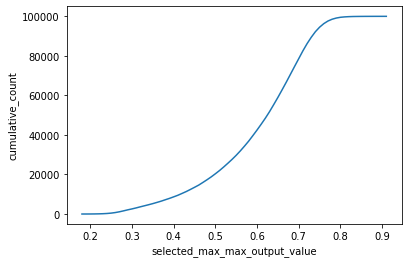

In [ ]:
# توزیع تجمعی مقادیر خروجی بیشینه
import matplotlib.pyplot as plt

cum_values = []
values = []

interval_number = 100
for i in range(18, 92):
    cum_values.append(np.where(sofmax_values < ((i+1) / interval_number))[0].shape[0])
    values.append(np.where(((i / interval_number) < sofmax_values) & (sofmax_values < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(18, 92)) / interval_number
ax.plot(x, cum_values)

plt.xlabel('selected_max_max_output_value')
plt.ylabel('cumulative_count')

plt.savefig('output_cumulative_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

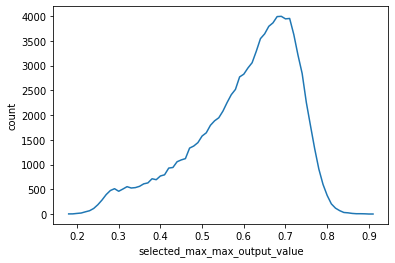

In [ ]:
# توزیع مقادیر خروجی بیشینه
import matplotlib.pyplot as plt

values = []
interval_number = 100
for i in range(18, 92):
    values.append(np.where(((i / interval_number) < sofmax_values) & (sofmax_values < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(18, 92)) / interval_number
ax.plot(x, values)

plt.xlabel('selected_max_max_output_value')
plt.ylabel('count')

plt.savefig('max_max_output_distribution.png', dpi=300, bbox_inches='tight')

plt.show()
# np.where(sofmax_values > 0.95)[0].shape[0] / len(testx)

In [ ]:
false_count = 0
true_count = 0
false_values = []
true_values = []
for i in range(len(testx)):
    if softmax_classes[i] != i // 5:
        false_count += 1
        false_values.append(sofmax_values[i])
    else:
        true_count += 1
        true_values.append(sofmax_values[i])

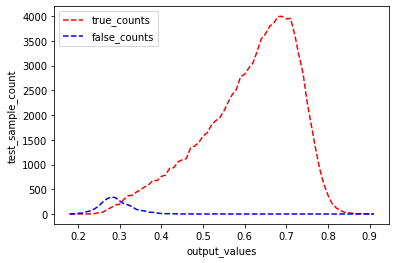

In [ ]:
# توزیع مقادیر خروجی بیشینه صحیح
import matplotlib.pyplot as plt

t_values = []
f_values = []

interval_number = 100
for i in range(18, 92):
    t_values.append(np.where(((i / interval_number) < np.array(true_values)) & (np.array(true_values) < ((i+1) / interval_number)))[0].shape[0])
    f_values.append(np.where(((i / interval_number) < np.array(false_values)) & (np.array(false_values) < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the data
x = np.array(range(18, 92)) / interval_number
ax.plot(x, t_values, 'r--', x, f_values, 'b--')

plt.legend(['true_counts', 'false_counts'])

plt.xlabel('output_values')
plt.ylabel('test_sample_count')

plt.savefig('max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


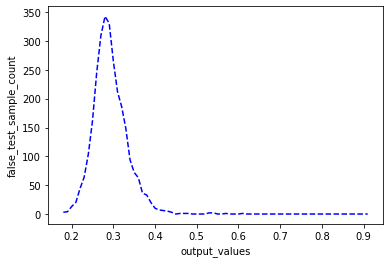

In [ ]:
# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the data
x = np.array(range(18, 92)) / interval_number
ax.plot(x, f_values, 'b--')

plt.xlabel('output_values')
plt.ylabel('false_test_sample_count')

plt.savefig('false_max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
f_percent = (np.array(f_values) / np.array(values))
t_percent = (np.array(t_values) / np.array(values))

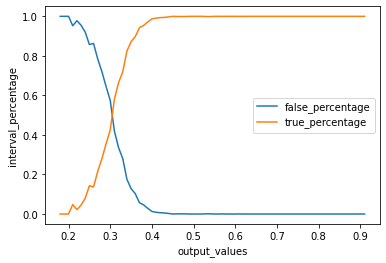

In [ ]:
# توزیع مقادیر خروجی بیشینه غلط
import matplotlib.pyplot as plt

# f_p = []
# interval_number = 100
# for i in range(18, 92):
#     f_p.append(np.where(((i / interval_number) < np.array(f_percent)) & (np.array(f_percent) < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(18, 92)) / interval_number
ax.plot(x, f_percent, x, t_percent)

plt.legend(['false_percentage', 'true_percentage'])

plt.xlabel('output_values')
plt.ylabel('interval_percentage')

plt.savefig('percent_max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
len(values), len(f_values)

(100, 100)

In [ ]:
max_max_precision_array = np.divide(max_max_true_prec, (max_max_true_prec + max_max_false_prec), out=np.zeros_like(max_max_true_prec), where=(max_max_false_prec + max_max_true_prec)!=0)
max_max_recall_array = np.divide(max_max_true_recall, (max_max_true_recall + max_max_false_recall), out=np.zeros_like(max_max_true_recall), where=(max_max_false_recall + max_max_true_recall)!=0)

max_max_f_score_x = 2 * max_max_precision_array * max_max_recall_array
max_max_f_score_y = max_max_precision_array + max_max_recall_array
max_max_fscore_array =  np.divide(max_max_f_score_x, max_max_f_score_y, out=np.zeros_like(max_max_f_score_x), where=(max_max_f_score_y)!=0)

max_max_precision = np.sum(max_max_precision_array) / n_classes
max_max_recall = np.sum(max_max_recall_array) / n_classes
max_max_fscore = np.sum(max_max_fscore_array) / n_classes

max_max_precision, max_max_recall, max_max_fscore

max_max_report = metrics.classification_report(testl, softmax_classes, output_dict=True, zero_division=0)
print(max_max_report['accuracy'], max_max_report['macro avg'], max_max_report['weighted avg'])

(0.9787912323787324, 0.9718900000000001, 0.9717739254219554)

In [ ]:
max_max_report = metrics.classification_report(testl, softmax_classes, output_dict=True, zero_division=0)
print(max_max_report['accuracy'], max_max_report['macro avg'], max_max_report['weighted avg'])

0.97189 {'precision': 0.9787912323787324, 'recall': 0.9718900000000001, 'f1-score': 0.9717739254219554, 'support': 100000} {'precision': 0.9787912323787322, 'recall': 0.97189, 'f1-score': 0.9717739254219554, 'support': 100000}


In [ ]:
pairs = []
for idx, s in enumerate(softmax_classes):
    if (idx // 5) != s:
        pairs.append([idx, int(s.item())])

In [ ]:
len(pairs)

1127

In [ ]:
(1- 0.98114)*50000

942.9999999999994

In [ ]:
sofmax_values

tensor([0.7039, 0.6940, 0.7845,  ..., 0.6685, 0.5220, 0.5741])

In [ ]:
[[p[0], p[0] // 5, p[1]] for p in pairs]

[[24, 4, 747],
 [47, 9, 1422],
 [48, 9, 1014],
 [96, 19, 7303],
 [98, 19, 3576],
 [116, 23, 8988],
 [228, 45, 3526],
 [229, 45, 5708],
 [256, 51, 4882],
 [349, 69, 5790],
 [411, 82, 2916],
 [440, 88, 5705],
 [444, 88, 9935],
 [500, 100, 6107],
 [563, 112, 8561],
 [642, 128, 890],
 [648, 129, 1371],
 [715, 143, 3389],
 [728, 145, 1184],
 [768, 153, 8599],
 [829, 165, 9225],
 [934, 186, 7949],
 [1113, 222, 1880],
 [1190, 238, 4728],
 [1218, 243, 5159],
 [1273, 254, 7420],
 [1298, 259, 1534],
 [1299, 259, 2197],
 [1361, 272, 2543],
 [1383, 276, 5400],
 [1391, 278, 2531],
 [1578, 315, 4060],
 [1712, 342, 1581],
 [1800, 360, 1392],
 [1829, 365, 6545],
 [1900, 380, 9641],
 [1901, 380, 3034],
 [1929, 385, 6544],
 [1956, 391, 2222],
 [1993, 398, 2075],
 [1999, 399, 3805],
 [2010, 402, 4998],
 [2077, 415, 1820],
 [2084, 416, 1610],
 [2099, 419, 2916],
 [2104, 420, 5924],
 [2117, 423, 6984],
 [2125, 425, 693],
 [2141, 428, 1098],
 [2142, 428, 7970],
 [2153, 430, 7075],
 [2199, 439, 2044],
 [2205

In [ ]:
xs = []
for p in pairs:
    x = utility_functions.cos_sim(torch.Tensor(np.array([testx[p[0]]])), torch.Tensor(np.array([traincenterx[p[1]]])))[0]
    # x = sofmax_values[p[0]]
    print(x)
    # if 0.2 < x < 0.3:
    #     print(p, x)
    #     xs.append(x)
# np.min(xs)

tensor([0.3194])
tensor([0.4292])
tensor([0.3341])
tensor([0.3127])
tensor([0.3013])
tensor([0.2394])
tensor([0.3463])
tensor([0.3208])
tensor([0.2430])
tensor([0.2894])
tensor([0.2881])
tensor([0.2645])
tensor([0.2695])
tensor([0.3285])
tensor([0.3847])
tensor([0.2774])
tensor([0.2923])
tensor([0.2677])
tensor([0.3260])
tensor([0.3890])
tensor([0.2798])
tensor([0.2461])
tensor([0.2777])
tensor([0.2906])
tensor([0.4307])
tensor([0.3062])
tensor([0.3286])
tensor([0.2787])
tensor([0.3194])
tensor([0.2631])
tensor([0.4182])
tensor([0.3123])
tensor([0.2536])
tensor([0.3861])
tensor([0.2700])
tensor([0.2949])
tensor([0.2824])
tensor([0.3364])
tensor([0.4109])
tensor([0.2567])
tensor([0.3801])
tensor([0.3281])
tensor([0.3089])
tensor([0.2746])
tensor([0.2650])
tensor([0.3261])
tensor([0.3264])
tensor([0.2149])
tensor([0.2769])
tensor([0.2141])
tensor([0.2110])
tensor([0.3102])
tensor([0.3731])
tensor([0.2610])
tensor([0.3515])
tensor([0.2336])
tensor([0.3052])
tensor([0.3635])
tensor([0.2491

In [ ]:
dic = dict()
if n_clusters > 1:
    dic = torch.load('dic.torch')
# print("  idx|", "bad_soft|", "bad_knn|", "real_cl|", "pred_knn|", "pred_soft|", "max_max_val|", "sim_real_cl|", "sim_best_knn|", "sim_max_max|")

for idx, t in (enumerate(testx)):
    z = None # sofmax_values[idx].numpy().item()
    p = [idx // 5, int(softmax_classes[idx])]
    index = np.where(np.array(pairs)[:,0] == idx)[0]
    if len(index) > 0:
        p = pairs[index.item()]
        z = utility_functions.cos_sim(torch.Tensor(np.array([testx[p[0]]])), torch.Tensor(np.array([traincenterx[p[1]]])))[0].numpy()[0]
    x = utility_functions.cos_sim(torch.Tensor(np.array([t])), torch.Tensor(np.array([traincenterx[idx // 5]])))[0]
    y = utility_functions.cos_sim(torch.Tensor(np.array([t])), torch.Tensor(np.array(traincenterx)))[0].numpy()
    if not z:
        z = np.max(y)
    type1 = (idx // 5) != np.argmax(y)
    type2 = len(index) > 0 # or (p[1] != (idx // 5))
    # if type2:
    #     print(len(index))
    #     print(p[1])
    #     print(idx // 5)
    if type1 or type2:
        ddd = {'bad_knn':type1, 'real_class':idx//5, 'pred_knn': np.argmax(y), 'sim_real_cl':x.numpy()[0], 'sim_best_knn': np.max(y)}
        if method == 'kmeans' and n_clusters == 1:
            ddd['pred_soft'] = p[1]
            ddd['bad_soft'] = type2
            ddd['soft_val'] = sofmax_values[idx].item()
            ddd['sim_soft'] = z
        if method == 'full_random' and n_clusters > 1:
            print(idx)
            ddd['pred_max_max'] = p[1]
            ddd['bad_max_max'] = type2
            ddd['max_max_val'] = sofmax_values[idx].item()
            ddd['sim_max_max'] = z

        if idx in dic:
            dic[idx].update(ddd)
        else:
            dic[idx] = ddd
        # print('{:>5}|'.format(idx), '{:>8}|'.format(str(type2)), '{:>7}|'.format(str(type1)), '{:>7}|'.format(idx//5), \
        #     '{:>8}|'.format(np.argmax(y)), '{:>9}|'.format(p[1]), '{:11.6f}|'.format(sofmax_values[idx].item()), '{:11.6f}|'.format(x.numpy()[0]), \
        #     '{:12.6f}|'.format(np.max(y)), '{:>11}|'.format(str(z)))
        # break

24
47
48
88
96
98
116
220
228
229
256
349
411
434
440
444
500
563
642
648
691
715
728
740
745
768
829
899
934
1029
1113
1149
1160
1169
1190
1218
1273
1298
1299
1361
1383
1391
1486
1578
1712
1800
1829
1900
1901
1929
1956
1993
1999
2010
2077
2084
2099
2104
2117
2125
2141
2142
2153
2199
2205
2227
2322
2402
2412
2413
2414
2438
2439
2482
2623
2627
2690
2691
2772
2782
2839
2884
2902
3011
3031
3050
3074
3129
3164
3167
3171
3178
3187
3197
3217
3233
3276
3303
3317
3387
3393
3435
3446
3451
3452
3453
3454
3544
3554
3569
3716
3720
3876
3989
4018
4097
4119
4128
4143
4148
4155
4162
4163
4164
4223
4272
4285
4292
4334
4394
4433
4488
4523
4535
4549
4572
4640
4642
4746
4760
4769
4834
4937
5004
5098
5127
5156
5165
5168
5198
5246
5479
5494
5604
5617
5619
5625
5788
5792
5837
5864
5893
5927
5939
5947
5949
5962
5966
6015
6024
6052
6082
6094
6173
6197
6241
6253
6258
6372
6373
6384
6464
6465
6603
6689
6725
6727
6773
6777
6779
6797
6804
6819
6852
6906
6926
6953
6993
6994
6998
7009
7039
7040
7079
7094
7104
7109


In [ ]:
dic

{46: {'bad_soft': True,
  'bad_knn': False,
  'real_class': 9,
  'pred_knn': 9,
  'sim_real_cl': 0.3787729,
  'sim_best_knn': 0.3787729,
  'pred_soft': 5742,
  'soft_val': 0.27831315994262695,
  'sim_soft': 0.25589907},
 47: {'bad_soft': True,
  'bad_knn': True,
  'real_class': 9,
  'pred_knn': 1422,
  'sim_real_cl': 0.33357036,
  'sim_best_knn': 0.42919788,
  'pred_soft': 1422,
  'soft_val': 0.332141250371933,
  'sim_soft': 0.42919788,
  'pred_max_max': 1422,
  'bad_max_max': True,
  'max_max_val': 0.34811079502105713,
  'sim_max_max': 0.42919788},
 48: {'bad_soft': True,
  'bad_knn': False,
  'real_class': 9,
  'pred_knn': 9,
  'sim_real_cl': 0.34057662,
  'sim_best_knn': 0.34057662,
  'pred_soft': 5934,
  'soft_val': 0.2668454647064209,
  'sim_soft': 0.27725807,
  'pred_max_max': 1014,
  'bad_max_max': True,
  'max_max_val': 0.28383156657218933,
  'sim_max_max': 0.33405167},
 77: {'bad_soft': True,
  'bad_knn': False,
  'real_class': 15,
  'pred_knn': 15,
  'sim_real_cl': 0.40127861

In [ ]:
# methods = ["full_random", "half_random", "kmeans", "sample_kmeans"]
keys = ['idx', 'bad_knn', 'real_class', 'pred_knn', 'sim_real_cl', 'sim_best_knn', 'pred_soft', 'bad_soft', 'soft_val', 'sim_soft', 'pred_max_max', 'bad_max_max', 'max_max_val', 'sim_max_max']
result_dic = dict()
for k in keys:
    result_dic[k] = []

for d in dic:
    for k in keys:
        if k == 'idx':
            result_dic[k] += [d]
        elif k in dic[d]:
            result_dic[k] += [dic[d][k]]
        else:
            result_dic[k] += ['NaN']

In [ ]:
result_dic['sim_soft'] = list(np.array(result_dic['sim_soft']))
result_dic

{'idx': [46,
  47,
  48,
  77,
  88,
  96,
  98,
  116,
  220,
  228,
  229,
  235,
  237,
  246,
  256,
  317,
  349,
  411,
  434,
  444,
  500,
  563,
  642,
  648,
  691,
  715,
  728,
  740,
  745,
  768,
  771,
  829,
  864,
  892,
  899,
  934,
  957,
  1029,
  1138,
  1149,
  1154,
  1160,
  1169,
  1183,
  1190,
  1218,
  1273,
  1298,
  1299,
  1359,
  1361,
  1391,
  1486,
  1489,
  1578,
  1621,
  1676,
  1712,
  1779,
  1800,
  1853,
  1900,
  1901,
  1929,
  1956,
  1959,
  1993,
  1999,
  2010,
  2011,
  2014,
  2077,
  2084,
  2099,
  2104,
  2117,
  2125,
  2141,
  2142,
  2143,
  2144,
  2153,
  2159,
  2174,
  2198,
  2199,
  2205,
  2227,
  2322,
  2402,
  2412,
  2413,
  2414,
  2437,
  2438,
  2439,
  2482,
  2623,
  2627,
  2637,
  2691,
  2772,
  2782,
  2794,
  2818,
  2839,
  2884,
  2902,
  2971,
  2972,
  2974,
  3011,
  3031,
  3050,
  3074,
  3129,
  3133,
  3136,
  3164,
  3167,
  3171,
  3178,
  3187,
  3197,
  3199,
  3217,
  3254,
  3276,
  3311,
  331

In [ ]:
# len(result_dic['bad_knn']), len(result_dic['bad_max_max'])
import pandas as pd
new = pd.DataFrame.from_dict(result_dic)

In [ ]:
new.to_csv('new.csv', index=False)

In [ ]:
# np.where(new.query("bad_max_max == False and bad_knn == True")['bad_soft'].to_numpy())[0].shape
new.query("bad_max_max == False and bad_soft == False and bad_knn == True")

,idx,bad_knn,real_class,pred_knn,sim_real_cl,sim_best_knn,pred_soft,bad_soft,soft_val,sim_soft,pred_max_max,bad_max_max,max_max_val,sim_max_max
8,220,True,44,7272,0.263647,0.273097,44,False,0.276703,0.2767033,44,False,0.291689,0.273097
18,434,True,86,5632,0.379282,0.389031,86,False,0.293346,0.29334617,86,False,0.313597,0.389031
27,740,True,148,4400,0.297766,0.311228,148,False,0.403892,0.4038915,148,False,0.377757,0.311228
34,899,True,179,754,0.350931,0.363378,179,False,0.340076,0.34007648,179,False,0.346619,0.363378
39,1149,True,229,1172,0.432248,0.442383,229,False,0.420982,0.42098248,229,False,0.434871,0.442383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,48238,True,9647,7383,0.334514,0.338781,9647,False,0.383441,0.3834414,9647,False,0.354863,0.338781
1540,48555,True,9711,4302,0.219070,0.256552,9711,False,0.254419,0.25441867,9711,False,0.295279,0.256552
1550,48795,True,9759,1933,0.412487,0.420583,9759,False,0.394274,0.39427388,9759,False,0.366673,0.420583
1572,49308,True,9861,7808,0.320856,0.349858,9861,False,0.340926,0.3409263,9861,False,0.344722,0.349858


In [ ]:
torch.save(dic, 'new_dic.torch')
torch.save(result_dic, 'result_dic.torch')

In [ ]:
# n_clusters = 10
# centers, labels = clustering.init_centers(traincenterx, n_clusters)
# model = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, centroids=centers, mode="cosine", minibatch=None)
# lbls = model.fit_predict(torch.Tensor(traincenterx).cuda())
# for i in range(n_clusters):
#     result[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)

# for r in result:
#     unique_result[r] = result[r]

In [ ]:
# pr = model.predict(torch.Tensor(testx))

In [ ]:
# trues = 0
# falses = 0
# for idx, p in enumerate(pr):
#     if testl[idx] in result[p.item()]:
#         trues += 1
#     else:
#         falses += 1
# trues / (trues + falses)

In [ ]:
# data = dict()
# lbls = dict()
# for idx, l in enumerate(labels):
#     lbls[l] = idx
# for i in range(n_clusters):
#     data[i] = [centers[i]]

# for i, train in tqdm(enumerate(traincenterx)):
#     max_best = -1
#     for j, cntr in enumerate(centers):
#         d = utility_functions.cos_sim(torch.Tensor([train]), torch.Tensor(data[j]))
#         best = d.max()
#         if best > max_best:
#             max_best = best
#             max_idx = j
#     data[max_idx].append(train)
#     lbls[i] = max_idx

In [ ]:
# np.savez_compressed(file=join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_nearest_clustering.npz'), res = data)
# d = np.load(join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_nearest_clustering.npz'), allow_pickle=True)['res'].item()

# res = dict()
# for i in range(n_clusters):
#     res[i] = []
# for l in lbls:
#     res[lbls[l]] += [l]

# for r in res:
#     res[r] = np.array(np.sort(res[r]))

# np.savez_compressed(file=join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_nearest_clustering_result.npz'), res = res)
# result = np.load(join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_nearest_clustering_result.npz'), allow_pickle=True)['res'].item()

In [ ]:
# batch_size = 10000
# batch_numbers = len(testx) // batch_size + 1
# nearests = []
# for batch in tqdm(range(batch_numbers)):
#     batch_distances = utility_functions.cos_sim(torch.Tensor(testx[batch * batch_size: np.min([len(testx), (batch+1) * batch_size])]), torch.Tensor(traincenterx)).numpy()
#     nearests.extend(np.argmax(batch_distances, 1))
# nearests = np.array(nearests)

In [ ]:
# trues = 0
# falses = 0

# for idx, test in (enumerate(testx)):
#     pred_cluster = None
#     real_cluster = None
#     for r in res:
#         if testl[idx] in res[r]:
#             real_cluster = r
    
#     for r in res:
#         if nearests[idx].item() in res[r]:
#             pred_cluster = r

#     if pred_cluster == real_cluster:
#         trues += 1
#     else:
#         falses += 1

#     if (idx + 1) % 1000 == 0:
#         print(idx + 1, trues / (trues + falses))
# trues / (trues + falses)

In [ ]:
# trues = 0
# falses = 0

# for idx, test in (enumerate(testx)):
#     pred_cluster = None
#     real_cluster = None
#     for r in result:
#         if testl[idx] in result[r]:
#             real_cluster = r
    
#     for r in result:
#         if nearests[idx].item() in result[r]:
#             pred_cluster = r

#     if pred_cluster == real_cluster:
#         trues += 1
#     else:
#         falses += 1

#     if (idx + 1) % 1000 == 0:
#         print(idx + 1, trues / (trues + falses))
# trues / (trues + falses)

In [ ]:
# # our method
# if len(unique_result) == 1:
#     trues = 0
#     falses = 0
#     for test_sample in range(len(testx)):
#         real_class = testl[test_sample]
#         pred_class = argmax_softmax[test_sample][0]
#         if pred_class == real_class:
#             trues += weights[test_sample]
#         else:
#             falses += weights[test_sample]

#         # if (test_sample + 1) % 10000 == 0:
#         #     print(test_sample + 1, trues / (trues + falses))    

#     pprint((test_sample + 1, trues / (trues + falses)))

# # res = (sim_values * 1.3 * ((sim_softmax+1)/2)).numpy() > (sofmax_values * ((np.array(softmax_sims)+1)/2))

# elif meth != 'sample_kmeans':
#     max_max_trues = 0
#     knn_trues = 0
#     mixed_trues = 0
#     max_max_falses = 0
#     knn_falses = 0
#     mixed_falses = 0

#     index = 0
#     # cc = None

#     for test_sample in range(len(testx)):
#         if meth == 'half_random':
#             ssw = False
#             for t in temp:
#                 if testl[test_sample] in temp[t]:
#                     ssw = True
#                     break
#             if ssw:
#                 max_max_falses += weights[test_sample]
#                 knn_falses += weights[test_sample]
#                 mixed_falses += weights[test_sample]
#                 continue

#         real_class = testl[test_sample]
#         # real_cluster = np.where([real_class in unique_result[i] for i in range(n_clusters)])[0][0]
#         # class_in_cluster = np.where(unique_result[real_cluster] == real_class)[0][0]
#         # # real_class_softmax_value = models[real_cluster].predict(np.array([temp_testx[test_sample]]))[0][class_in_cluster]
#         # # real_class_knn_value = cc[test_sample, test_sample].numpy()

#         # softmax_softmax_cluster = np.argmax(max_softmax[test_sample])
#         # softmax_softmax_class = unique_result[softmax_softmax_cluster][argmax_softmax[test_sample][softmax_softmax_cluster]]
#         # softmax_softmax_value = max_softmax[test_sample][softmax_softmax_cluster]
#         # # if index != len(points):
#         # #     if test_sample == points[index]:
#         # #         cc = torch.load(join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_cos_sim_' + str(index) + '.npz'))
#         # #         index += 1

#         if sofmax_values[test_sample] > 0.5:
#             if softmax_classes[test_sample] == real_class:
#                 max_max_trues += weights[test_sample]
#                 knn_trues += weights[test_sample]
#                 mixed_trues += weights[test_sample]
#             else:
#                 max_max_falses += weights[test_sample]
#                 knn_falses += weights[test_sample]
#                 mixed_falses += weights[test_sample]
#         else:
#             if softmax_classes[test_sample] != real_class:
#                 max_max_falses += weights[test_sample]
#             elif softmax_classes[test_sample] == real_class:         
#                 max_max_trues += weights[test_sample]

#         if res[test_sample]:
#             if sim_classes[test_sample] == real_class:
#                 mixed_trues += weights[test_sample]
#                 knn_trues += weights[test_sample]
#             else:
#                 mixed_falses += weights[test_sample]
#                 knn_falses += weights[test_sample]
#             if softmax_classes[test_sample] == real_class:
#                 max_max_trues += weights[test_sample]
#             else:
#                 max_max_falses += weights[test_sample]
#         else:
#             if softmax_classes[test_sample] == real_class:
#                 mixed_trues += weights[test_sample]
#                 max_max_trues += weights[test_sample]
#             else:
#                 mixed_falses += weights[test_sample]
#                 max_max_falses += weights[test_sample]
#             if sim_classes[test_sample] == real_class:
#                 knn_trues += weights[test_sample]
#             else:
#                 knn_falses += weights[test_sample]





#             knn_knn_cluster = None
#             knn_knn_value = -1
#             for f in unique_result:
#                 g = utility_functions.cos_sim(torch.Tensor([testx[test_sample]]), torch.Tensor(traincenterx[unique_result[f]]))
#                 temp_knn_knn_class = unique_result[f][np.argmax(g).item()]
#                 temp_knn_knn_value = np.max(g.numpy())
#                 if temp_knn_knn_value > knn_knn_value:
#                     knn_knn_cluster = f
#                     knn_knn_value = temp_knn_knn_value
#                     knn_knn_class = temp_knn_knn_class
#             # knn_knn_cluster = np.where([knn_knn_class in unique_result[i] for i in range(n_clusters)])[0][0]
#             knn_softmax_class = unique_result[knn_knn_cluster][argmax_softmax[test_sample][knn_knn_cluster]]

#             knn_knn_class = np.argmax(cc[np.max([0, test_sample - ((index-1) * batch_size)])]).item()
#             try:
#                 knn_knn_cluster = np.where([knn_knn_class in unique_result[i] for i in range(n_clusters)])[0][0]
#             except:
#                 knn_falses += weights[test_sample]
#                 mixed_falses += weights[test_sample]
#                 continue

#             knn_softmax_class = unique_result[knn_knn_cluster][argmax_softmax[test_sample][knn_knn_cluster]]

#             # class_in_cluster = np.where(unique_result[knn_knn_cluster] == knn_knn_class)[0][0]
#             # knn_softmax_value = models[knn_knn_cluster].predict(np.array([testx[test_sample]]))[0][class_in_cluster]
#             # # knn_knn_value = cc[np.max([0, test_sample - ((index-1) * batch_size)])].max().item()
#             # # softmax_knn_value = cc[np.max([0, test_sample -((index-1) * batch_size)]), softmax_softmax_class].item()
#             # softmax_knn_value = utility_functions.cos_sim(torch.Tensor([testx[test_sample]]), torch.Tensor([traincenterx[softmax_softmax_class]])).item()

#             if knn_knn_class == softmax_softmax_class:
#                 if knn_knn_class == real_class:
#                     mixed_trues += weights[test_sample]
#                     knn_trues += weights[test_sample]
#                 else:
#                     mixed_falses += weights[test_sample]
#                     knn_falses += weights[test_sample]
#             else:
#                 if knn_softmax_class == real_class:
#                     knn_trues += weights[test_sample]
#                 else:
#                     knn_falses += weights[test_sample]        

#                 if knn_softmax_value * knn_knn_value > softmax_softmax_value * softmax_knn_value:
#                     if knn_knn_class == real_class:
#                         mixed_trues += weights[test_sample]
#                     else:
#                         mixed_falses += weights[test_sample]
#                 else:
#                     if softmax_softmax_class == real_class:
#                         mixed_trues += weights[test_sample]
#                     else:
#                         mixed_falses += weights[test_sample]

#         if (test_sample + 1) % 1000 == 0:
#             pprint((test_sample + 1, max_max_trues / (max_max_trues + max_max_falses), knn_trues / (knn_trues + knn_falses), mixed_trues / (mixed_trues + mixed_falses)))    

#     pprint((test_sample + 1, max_max_trues / (max_max_trues + max_max_falses), knn_trues / (knn_trues + knn_falses), mixed_trues / (mixed_trues + mixed_falses)))    

# # اگر خواستیم از پایینی استفاده کنیم، به شکل اصلاح شده بالایی درآوریم
# # # our method for fuzzy_clustering
# # elif meth == 'sample_kmeans':
# #     max_max_trues = 0
# #     knn_trues = 0
# #     mixed_trues = 0
# #     max_max_falses = 0
# #     knn_falses = 0
# #     mixed_falses = 0

# #     index = 0
# #     cc = None
# #     for test_sample in range(len(testx)):
# #         real_class = testl[test_sample]
# #         real_cluster = np.where([real_class in unique_result[i] for i in range(n_clusters)])[0][0]
# #         class_in_cluster = np.where(unique_result[real_cluster] == real_class)[0][0]
# #         # real_class_softmax_value = models[real_cluster].predict(np.array([temp_testx[test_sample]]))[0][class_in_cluster]
# #         # real_class_knn_value = cc[test_sample, test_sample].numpy()

# #         softmax_softmax_cluster = np.argmax(max_softmax[test_sample])
# #         softmax_softmax_class = unique_result[softmax_softmax_cluster][argmax_softmax[test_sample][softmax_softmax_cluster]]
# #         softmax_softmax_value = max_softmax[test_sample][softmax_softmax_cluster]
# #         # if index != len(points):
# #         #     if test_sample == points[index]:
# #         #         cc = torch.load(join('..', dataset_name, 'data', str(n_classes), str(n_classes) + '_cos_sim_' + str(index) + '.npz'))
# #         #         index += 1

# #         if sofmax_values[test_sample] > 0.5:
# #             if softmax_classes[test_sample] == real_class
# #                 max_max_trues += weights[test_sample]
# #                 knn_trues += weights[test_sample]
# #                 mixed_trues += weights[test_sample]
# #             else:
# #                 max_max_falses += weights[test_sample]
# #                 knn_falses += weights[test_sample]
# #                 mixed_falses += weights[test_sample]
# #         else:
# #             if softmax_softmax_class != real_class:
# #                 max_max_falses += weights[test_sample]
# #             elif softmax_softmax_class == real_class:         
# #                 max_max_trues += weights[test_sample]
        
# #             # knn_knn_class = np.argmax(cc[np.max([0, test_sample - ((index-1) * batch_size)])]).item()
# #             selected_cluster_value = -1
# #             knn_knn_cluster = None
# #             knn_knn_value = -1
# #             for f in unique_result:
# #                 g = utility_functions.cos_sim(torch.Tensor([testx[test_sample]]), torch.Tensor(traincenterx[unique_result[f]]))
# #                 temp_knn_knn_class = unique_result[f][np.argmax(g).item()]
# #                 temp_knn_knn_value = np.max(g.numpy())
# #                 if temp_knn_knn_value > knn_knn_value:
# #                     knn_knn_cluster = f
# #                     knn_knn_value = temp_knn_knn_value
# #                     knn_knn_class = temp_knn_knn_class
# #             # knn_knn_cluster = np.where([knn_knn_class in unique_result[i] for i in range(n_clusters)])[0][0]
# #             knn_softmax_class = unique_result[knn_knn_cluster][argmax_softmax[test_sample][knn_knn_cluster]]

# #             class_in_cluster = np.where(unique_result[knn_knn_cluster] == knn_knn_class)[0][0]
# #             knn_softmax_value = models[knn_knn_cluster].predict(np.array([testx[test_sample]]))[0][class_in_cluster]
# #             # knn_knn_value = cc[np.max([0, test_sample - ((index-1) * batch_size)])].max().item()
# #             # softmax_knn_value = cc[np.max([0, test_sample -((index-1) * batch_size)]), softmax_softmax_class].item()
# #             softmax_knn_value = utility_functions.cos_sim(torch.Tensor([testx[test_sample]]), torch.Tensor([traincenterx[softmax_softmax_class]]))

# #             if knn_knn_class == softmax_softmax_class:
# #                 if knn_knn_class == real_class:
# #                     mixed_trues += weights[test_sample]
# #                     knn_trues += weights[test_sample]
# #                 else:
# #                     mixed_falses += weights[test_sample]
# #                     knn_falses += weights[test_sample]
# #             else:
# #                 if knn_softmax_class == real_class:
# #                     knn_trues += weights[test_sample]
# #                 else:
# #                     knn_falses += weights[test_sample]        

# #                 if knn_softmax_value * knn_knn_value > softmax_softmax_value * softmax_knn_value:
# #                     if knn_knn_class == real_class:
# #                         mixed_trues += weights[test_sample]
# #                     else:
# #                         mixed_falses += weights[test_sample]
# #                 else:
# #                     if softmax_softmax_class == real_class:
# #                         mixed_trues += weights[test_sample]
# #                     else:
# #                         mixed_falses += weights[test_sample]


# #         if (test_sample + 1) % 1000 == 0:
# #             pprint((test_sample + 1, max_max_trues / (max_max_trues + max_max_falses), knn_trues / (knn_trues + knn_falses), mixed_trues / (mixed_trues + mixed_falses)))

# #     pprint((test_sample + 1, max_max_trues / (max_max_trues + max_max_falses), knn_trues / (knn_trues + knn_falses), mixed_trues / (mixed_trues + mixed_falses)))


In [ ]:
# # very important: for feature extraction balanced test dataset
# import onnx
# import warnings
# from onnx_tf.backend import prepare
# import numpy as np
# from datetime import datetime
# import tensorflow as tf
# import os
# import cv2
# from tqdm import tqdm
# import PIL
# from PIL import Image


# all_ids = np.load('./id_files/glint_all_ids.npz')['res']
# warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

# onnx_model = onnx.load('F:/test/onnx_tensorflow/model.onnx')
# tf_rep = prepare(onnx_model) # Import the ONNX model to Tensorflow

In [ ]:
# import json
# all_id_files = dict()
# with open(os.path.join('..', 'glint360k_224', 'data', 'all_id_files.json')) as jsonfile:
#     all_id_files = json.load(jsonfile)

# keys = list(all_id_files.keys())[:100000]

In [ ]:
# dataset_path = 'E:/balanced_glint360k_224/test/'
# new_dataset_path = 'F:/test/deepface/glint360k_224/img_data'
# os.makedirs(new_dataset_path, exist_ok=True)
# os.makedirs(os.path.join(new_dataset_path, 'embeddings'), exist_ok=True)

# image_list = []
# begin = 99990
# idx = begin
# for d in tqdm(keys[begin:]):
#     if idx % 10 == 0 and idx > begin:
#         emb = tf_rep.run(np.array(image_list))._0
#         np.savez_compressed(os.path.join(new_dataset_path, 'embeddings', str(idx) + '.npz'), res=emb)
#         image_list = []
#     for f in os.listdir(os.path.join(dataset_path, d)):
#         img_path = os.path.join(dataset_path, d, f)
#         # img = cv2.imread(img_path)
#         try:
#             img = Image.open(img_path)
#         except:
#             try:
#                 img = Image.open(os.path.join('H:/glint360k_224/', d, f))
#             except:
#                 img = Image.open(os.path.join('D:/glint360k_224/', d, f))
#         x_train = tf.image.resize(np.array(img), (112, 112), method="nearest")
#         x_train = (tf.cast(x_train, tf.float32) - 127.5) / 128.
#         x_train = tf.transpose(x_train, perm=[2, 0, 1])
#         x_train = tf.expand_dims(x_train, 0)
#         image_list.extend(x_train)
#     idx += 1

In [ ]:
# import cv2
# import sys
# import numpy as np
# import mxnet as mx
# import os
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# from scipy import misc
# import random
# import sklearn
# from sklearn.decomposition import PCA
# from time import sleep
# from easydict import EasyDict as edict
# from mtcnn_detector import MtcnnDetector
# from skimage import transform as trans
# import matplotlib.pyplot as plt
# from mxnet.contrib.onnx.onnx2mx.import_model import import_model

In [ ]:
# import onnx
# from onnx_tf.backend import prepare

# # model_name = 'F:/test/onnx_tensorflow/model.onnx'
# # # model_name = 'C:\\Users\\Dianat\\Downloads\\arcfaceresnet100-8.onnx'
# # model = get_model(ctx , model_name)

# model = onnx.load('F:/test/onnx_tensorflow/model.onnx')
# tf_rep = prepare(model) # Import the ONNX model to Tensorflow

In [ ]:
# import tensorflow as tf
# # mx.test_utils.download('https://s3.amazonaws.com/onnx-model-zoo/arcface/player1.jpg')
# img = cv2.imread('player1.jpg')
# x_train = tf.image.resize(img, (112, 112), method="nearest")
# x_train = (tf.cast(x_train, tf.float32) - 127.5) / 128.
# x_train = tf.transpose(x_train, perm=[2, 1, 0])
# x_train = tf.expand_dims(x_train, 0)
# out1 = tf_rep.run(np.array(x_train))

In [ ]:
# batch_size = 10
# batch_numbers = len(all_ids) // batch_size + (1 if (len(all_ids) % batch_size != 0) else 0)
# print('started at : ', datetime.now().strftime('%y/%m/%d-%H:%M:%S'))
# for batch in tqdm(range(batch_numbers)):
# #     with tf.device('/cpu:0'):
# #     print(datetime.now().strftime('%y/%m/%d-%H:%M:%S'), batch, ' from ', batch_numbers, ' batchs')
#     selected_classes = all_ids[batch*batch_size:min(len(all_classes), (batch+1)*batch_size)]

#     data = []
#     for id in (selected_classes):
#         x = np.load(join('E:/balanced_glint360k_224/test', str(id) + '.npz'), allow_pickle=True)
#         x = x[x.files[0]]
#         data += list(x)    
#     new_data = np.moveaxis(data, -1, 1)#[1,2], [3,2])
#     result = tf_rep.run(new_data)[0]

#     for idx, id in (enumerate(selected_classes)):
#         embs = result[max_sample_size*idx:max_sample_size*(idx+1)]
# #     np.savez_compressed('F:\\test\\deepface\\250k_dataset\\embeddings\\common\\' + str(id) + '.npz')
#         np.savetxt(join('..', dataset_name, 'embeddings', 'common', str(id) + '.csv'), embs, delimiter=",")
#     #     for load:
#     # data = np.loadtxt('data.csv', delimiter=',')    
# print('finished at : ', datetime.now().strftime('%y/%m/%d-%H:%M:%S'))


In [ ]:
# from sklearn.datasets import fetch_lfw_pairs
# lfw_pairs_test = fetch_lfw_pairs(subset = 'test')
# pairs = lfw_pairs_test.pairs
# # target = fetch_lfw_pairs.target
# target = lfw_pairs_test.target

In [ ]:
# def get_val_pair(path, name):
#     carray = bcolz.carray(rootdir=os.path.join(path, name), mode='r')
#     issame = np.load('{}/{}_list.npy'.format(path, name))

#     return carray, issame


# def get_lfw_data(data_path):
#     """get validation data"""
#     _lfw, _lfw_issame = get_val_pair(data_path, 'lfw_align_112/lfw')

#     return _lfw, _lfw_issame


# def get_val_data(data_path):
#     """get validation data"""
#     _lfw, _lfw_issame = get_val_pair(data_path, 'lfw_align_112/lfw')
#     _agedb_30, _agedb_30_issame = get_val_pair(data_path, 'AgeDB/agedb_30')
#     _cfp_fp, _cfp_fp_issame = get_val_pair(data_path, 'cfp_align_112/cfp_fp')

#     return _lfw, _agedb_30, _cfp_fp, _lfw_issame, _agedb_30_issame, _cfp_fp_issame


# def test_on_val_data(model, lfw, lfw_issame, is_ccrop: bool = False, step_i: int = 1, alfa_multiplied_ten: int = 1):
#     step = int(alfa_multiplied_ten / step_i)

#     print("-----------------------------------")
#     acc_lfw, best_th = perform_val_arcface(512, 64, model, lfw, lfw_issame, is_ccrop=is_ccrop)
#     print(f"[*] Results on LFW, Accuracy --> {acc_lfw} || Best Threshold --> {best_th}")
#     print("-----------------------------------")

# def hflip_batch(imgs):
#     return imgs[:, :, ::-1, :]

# def l2_norm(x, axis=1):
#     """l2 norm"""
#     norm = np.linalg.norm(x, axis=axis, keepdims=True)
#     output = x / norm

#     return output
        
# def perform_val_arcface(embedding_size, batch_size, model,
#                         carray, issame, nrof_folds=10, is_ccrop=False, is_flip=True):
#     """perform val"""
#     embeddings = np.zeros([len(carray), embedding_size])

#     for idx in tqdm.tqdm(range(0, len(carray), batch_size)):
#         batch = carray[idx:idx + batch_size]
#         batch = np.transpose(batch, [0, 2, 3, 1])
#         b, g, r = tf.split(batch, 3, axis=-1)
#         batch = tf.concat([r, g, b], -1)
#         if is_flip:
#             flipped = hflip_batch(batch)
#             emb_batch = model([batch, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1] + model([flipped, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1]
#             embeddings[idx:idx + batch_size] = l2_norm(emb_batch)
#         else:
#             emb_batch = model([batch, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1]
#             embeddings[idx:idx + batch_size] = l2_norm(emb_batch)

#     tpr, fpr, accuracy, best_thresholds = evaluate(
#         embeddings, issame, nrof_folds)

#     return accuracy.mean(), best_thresholds.mean()

In [ ]:
# lfw, lfw_issame = get_lfw_data("E:/datasets/test_dataset")

# carray = lfw
# embedding_size = 512
# batch_size = 64
# is_flip = False
# embeddings = np.zeros([len(carray), embedding_size])

In [ ]:
# for idx in tqdm(range(0, len(carray), batch_size)):
#     batch = carray[idx:idx + batch_size]
#     batch = np.transpose(batch, [0, 2, 3, 1])
#     b, g, r = tf.split(batch, 3, axis=-1)
#     batch = tf.concat([r, g, b], -1)
#     batch = tf.transpose(batch, perm=[0, 3, 1, 2])
#     emb = tf_rep.run(np.array(batch))._0
#     if is_flip:
#         flipped = hflip_batch(batch)
#         # emb_batch = model([batch, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1] + model([flipped, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1]
#         emb_batch = tf_rep.run(np.array(batch))._0 + tf_rep.run(np.array(flipped))._0
#         embeddings[idx:idx + batch_size] = l2_norm(emb_batch)
#     else:
#         # emb_batch = model([batch, tf.ones((batch.shape[0],), dtype=tf.int64)], training=False)[-1]
#         emb_batch = tf_rep.run(np.array(batch))
#         embeddings[idx:idx + batch_size] = l2_norm(emb_batch)

# np.savez_compressed('lfw_no_flip_embeddings.npz', res = embeddings)
# # return accuracy.mean(), best_thresholds.mean()

In [ ]:
# def calculate_accuracy(threshold, dist, actual_issame):
#     predict_issame = np.less(dist, threshold)
#     tp = np.sum(np.logical_and(predict_issame, actual_issame))
#     fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
#     tn = np.sum(np.logical_and(np.logical_not(predict_issame),
#                                np.logical_not(actual_issame)))
#     fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

#     tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
#     fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
#     _acc = float(tp + tn) / dist.size
#     return tpr, fpr, _acc


# def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame,
#                   nrof_folds=10):
#     assert (embeddings1.shape[0] == embeddings2.shape[0])
#     assert (embeddings1.shape[1] == embeddings2.shape[1])
#     nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
#     nrof_thresholds = len(thresholds)
#     k_fold = KFold(n_splits=nrof_folds, shuffle=False)

#     tprs = np.zeros((nrof_folds, nrof_thresholds))
#     fprs = np.zeros((nrof_folds, nrof_thresholds))
#     accuracy = np.zeros((nrof_folds,))
#     best_thresholds = np.zeros((nrof_folds,))
#     indices = np.arange(nrof_pairs)

#     diff = np.subtract(embeddings1, embeddings2)
#     dist = np.sum(np.square(diff), 1)

#     for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
#         # Find the best threshold for the fold
#         acc_train = np.zeros((nrof_thresholds,))
#         for threshold_idx, threshold in enumerate(thresholds):
#             _, _, acc_train[threshold_idx] = calculate_accuracy(
#                 threshold, dist[train_set], actual_issame[train_set])
#         best_threshold_index = np.argmax(acc_train)

#         best_thresholds[fold_idx] = thresholds[best_threshold_index]
#         for threshold_idx, threshold in enumerate(thresholds):
#             tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = \
#                 calculate_accuracy(threshold,
#                                    dist[test_set],
#                                    actual_issame[test_set])
#         _, _, accuracy[fold_idx] = calculate_accuracy(
#             thresholds[best_threshold_index],
#             dist[test_set],
#             actual_issame[test_set])

#     tpr = np.mean(tprs, 0)
#     fpr = np.mean(fprs, 0)
#     return tpr, fpr, accuracy, best_thresholds


# def evaluate(embeddings, actual_issame, nrof_folds=10):
#     # Calculate evaluation metrics
#     thresholds = np.arange(0, 4, 0.01)
#     embeddings1 = embeddings[0::2]
#     embeddings2 = embeddings[1::2]
#     tpr, fpr, accuracy, best_thresholds = calculate_roc(
#         thresholds, embeddings1, embeddings2, np.asarray(actual_issame),
#         nrof_folds=nrof_folds)

#     return tpr, fpr, accuracy, best_thresholds


# def perform_val(embedding_size, batch_size, model,
#                 carray, issame, nrof_folds=10, is_ccrop=False, is_flip=True):
#     """perform val"""
#     embeddings = np.zeros([len(carray), embedding_size])

#     for idx in tqdm.tqdm(range(0, len(carray), batch_size)):
#         batch = carray[idx:idx + batch_size]
#         batch = np.transpose(batch, [0, 2, 3, 1])
#         b, g, r = tf.split(batch, 3, axis=-1)
#         batch = tf.concat([r, g, b], -1)
#         if is_flip:
#             flipped = hflip_batch(batch)
#             emb_batch = model(batch, training=False) + model(flipped, training=False)
#             embeddings[idx:idx + batch_size] = l2_norm(emb_batch)
#         else:
#             emb_batch = model(batch, training=False)
#             embeddings[idx:idx + batch_size] = l2_norm(emb_batch)

#     tpr, fpr, accuracy, best_thresholds = evaluate(
#         embeddings, issame, nrof_folds)

#     return accuracy.mean(), best_thresholds.mean()

In [ ]:
# from sklearn.model_selection import KFold
# tpr, fpr, accuracy, best_thresholds = evaluate(embeddings, lfw_issame, nrof_folds=10)

# embeddings = np.load('lfw_flip_embeddings.npz')['res']
# tpr, fpr, accuracy, best_thresholds = evaluate(embeddings, lfw_issame, nrof_folds=10)
# accuracy.mean()

# preds = model(embeddings)
# ids = np.argmax(preds, 1)
# zero_ids = ids[0::2]
# one_ids = ids[1::2]
# res = (zero_ids == one_ids)
# f = (res == lfw_issame)
# len(np.where(f)[0]) / 6000